In [1]:
import sys
sys.path.append('/home/AI4OAC-VM1/notebooks/AI4OAC/generate_data')
sys.path.append('/home/AI4OAC-VM1/notebooks/AI4OAC/utils')
from generate_data import generate_data
import numpy as np
import matplotlib.pyplot as plt
import torch
from mpl_toolkits.mplot3d import Axes3D
import pickle

In [2]:
# generating training data
class GD:
    model = 'Adv_Dif_1D'
    class parameters:
        w = -0.01-0.5j
        x0 = 0.5
        t0 = 0
    dt_integration = 0.01# integration time
    dt_states = 1 # number of integeration times between consecutive states (for xt and catalog)
    dt_obs = 8# number of integration times between consecutive observations (for yo)
    var_obs = np.array([0,1]) # indices of the observed variables
    nb_loop_train = 1000.1 # size of the catalog
    nb_loop_test = 100 # size of the true state and noisy observations
    sigma2_catalog = 0.0 # variance of the model error to generate the catalog
    sigma2_obs = 2.0 # variance of the observation error to generate observation
    
# run the data generation
catalog, xt, yo = generate_data(GD)

#training data
batch_size = catalog.true_solution[:-10-1,:].shape[0]
X_train = np.reshape(catalog.true_solution[:-10-1,:],(int(catalog.true_solution[1:-10,:].shape[0]/batch_size),batch_size,catalog.true_solution[1:-10,:].shape[1]))
Grad_t  = np.reshape(np.gradient(X_train[0,:,0])/GD.dt_integration,(X_train.shape))
Y_train = np.reshape(catalog.true_solution[1:-10,:],(int(catalog.true_solution[1:-10,:].shape[0]/batch_size),batch_size,catalog.true_solution[1:-10,:].shape[1]))

In [3]:
X_train  = catalog.true_solution.real[:10000,:1]#[:-1,:1]
Grad_t   = np.gradient(X_train[:,0]).reshape(X_train.shape[0],1)/GD.dt_integration
Batch_size = 2000#X_train.shape[0]
nb_batch = int(X_train.shape[0]/Batch_size)

In [4]:
params = {}
params['dim_input']=1
params['dim_output']=2
params['dim_latent']=1
params['dim_observations'] = 2
params['dt_integration'] = GD.dt_integration
params['ntrain']=[2500]

In [5]:
class FC_net(torch.nn.Module):
        def __init__(self, params):
            super(FC_net, self).__init__()
            y_aug = np.random.uniform(size=(nb_batch,Batch_size,params['dim_latent']))
            self.y_aug = torch.nn.Parameter(torch.from_numpy(y_aug).float())
            self.linearCell   = torch.nn.Linear(params['dim_latent']+params['dim_input'], params['dim_latent']+params['dim_input'], bias = False) 
        def forward(self, inp, dt):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            if inp.shape[-1]<params['dim_latent']+params['dim_input']:
                aug_inp = torch.cat((inp, self.y_aug), dim=1)
            else:
                aug_inp = inp
            grad = self.linearCell(aug_inp)
            return grad, aug_inp
model  = FC_net(params)

In [6]:
class INT_net(torch.nn.Module):
        def __init__(self, params):
            super(INT_net, self).__init__()
#            self.add_module('Dyn_net',FC_net(params))
            self.Dyn_net = model
        def forward(self, inp, dt):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            
        
            if inp.shape[-1]<params['dim_latent']+params['dim_input']:
                k1, aug_inp   = self.Dyn_net(inp,dt)
                inp_k2 = 0.5*params['dt_integration']*k1
                inp_k2[:,:] = inp + 0.5*params['dt_integration']*k1[:,:]
                k2, tmp   = self.Dyn_net(inp_k2,dt)
                inp_k3 = 0.5*params['dt_integration']*k2
                inp_k3[:,:] = inp + 0.5*params['dt_integration']*k2[:,:]            
                k3, tmp   = self.Dyn_net(inp_k3,dt)
                inp_k4 = params['dt_integration']*k3
                inp_k4[:,:] = inp + params['dt_integration']*k3[:,:]            
                k4, tmp   = self.Dyn_net(inp_k4,dt)            
                pred = aug_inp +dt*(k1+2*k2+2*k3+k4)/6
            else : 
                k1, aug_inp   = self.Dyn_net(inp,dt)
                inp_k2 = 0.5*params['dt_integration']*k1
                inp_k2[:,:] = inp + 0.5*params['dt_integration']*k1
                k2, tmp   = self.Dyn_net(inp_k2,dt)
                inp_k3 = 0.5*params['dt_integration']*k2
                inp_k3[:,:] = inp + 0.5*params['dt_integration']*k2       
                k3, tmp   = self.Dyn_net(inp_k3,dt)
                inp_k4 = params['dt_integration']*k3
                inp_k4[:,:] = inp + params['dt_integration']*k3          
                k4, tmp   = self.Dyn_net(inp_k4,dt)            
                pred = aug_inp +dt*(k1+2*k2+2*k3+k4)/6    
                
            return pred, k1, inp, aug_inp

In [7]:
dt = params['dt_integration']
aug_vect = []
x = (torch.from_numpy(X_train.reshape(nb_batch,Batch_size,1)).float())
z = (torch.from_numpy(Grad_t.reshape(nb_batch,Batch_size,1)).float())

In [8]:
modelRINN = INT_net(params)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)

In [9]:
for t in range(params['ntrain'][0]):
    # Forward pass: Compute predicted y by passing x to the model
    for b in range(nb_batch):
        aug_inp = torch.cat((x[b,:,:],modelRINN.Dyn_net.y_aug[b,:,:]),dim = -1)
        pred, grad, inp, aug_inp = modelRINN(aug_inp,dt)
        
        # Compute and print loss
        loss1 = criterion(grad[:,:1], z[b,:,:])
        loss2 = criterion(pred[:-1,:], aug_inp[1:,:])
        loss = 1.0*loss1+1.0*loss2
        print(t,loss)
        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

0 tensor(0.1705, grad_fn=<AddBackward0>)
0 tensor(0.1362, grad_fn=<AddBackward0>)
0 tensor(0.1354, grad_fn=<AddBackward0>)
0 tensor(0.1366, grad_fn=<AddBackward0>)
0 tensor(0.1272, grad_fn=<AddBackward0>)
1 tensor(0.1670, grad_fn=<AddBackward0>)
1 tensor(0.1334, grad_fn=<AddBackward0>)
1 tensor(0.1328, grad_fn=<AddBackward0>)
1 tensor(0.1339, grad_fn=<AddBackward0>)
1 tensor(0.1247, grad_fn=<AddBackward0>)
2 tensor(0.1641, grad_fn=<AddBackward0>)
2 tensor(0.1309, grad_fn=<AddBackward0>)
2 tensor(0.1303, grad_fn=<AddBackward0>)
2 tensor(0.1313, grad_fn=<AddBackward0>)
2 tensor(0.1223, grad_fn=<AddBackward0>)
3 tensor(0.1613, grad_fn=<AddBackward0>)
3 tensor(0.1284, grad_fn=<AddBackward0>)
3 tensor(0.1279, grad_fn=<AddBackward0>)
3 tensor(0.1287, grad_fn=<AddBackward0>)
3 tensor(0.1199, grad_fn=<AddBackward0>)
4 tensor(0.1585, grad_fn=<AddBackward0>)
4 tensor(0.1259, grad_fn=<AddBackward0>)
4 tensor(0.1255, grad_fn=<AddBackward0>)
4 tensor(0.1261, grad_fn=<AddBackward0>)
4 tensor(0.1175,

41 tensor(0.0626, grad_fn=<AddBackward0>)
41 tensor(0.0587, grad_fn=<AddBackward0>)
42 tensor(0.0876, grad_fn=<AddBackward0>)
42 tensor(0.0658, grad_fn=<AddBackward0>)
42 tensor(0.0641, grad_fn=<AddBackward0>)
42 tensor(0.0615, grad_fn=<AddBackward0>)
42 tensor(0.0577, grad_fn=<AddBackward0>)
43 tensor(0.0863, grad_fn=<AddBackward0>)
43 tensor(0.0649, grad_fn=<AddBackward0>)
43 tensor(0.0631, grad_fn=<AddBackward0>)
43 tensor(0.0605, grad_fn=<AddBackward0>)
43 tensor(0.0567, grad_fn=<AddBackward0>)
44 tensor(0.0852, grad_fn=<AddBackward0>)
44 tensor(0.0639, grad_fn=<AddBackward0>)
44 tensor(0.0621, grad_fn=<AddBackward0>)
44 tensor(0.0594, grad_fn=<AddBackward0>)
44 tensor(0.0557, grad_fn=<AddBackward0>)
45 tensor(0.0840, grad_fn=<AddBackward0>)
45 tensor(0.0630, grad_fn=<AddBackward0>)
45 tensor(0.0611, grad_fn=<AddBackward0>)
45 tensor(0.0584, grad_fn=<AddBackward0>)
45 tensor(0.0548, grad_fn=<AddBackward0>)
46 tensor(0.0829, grad_fn=<AddBackward0>)
46 tensor(0.0621, grad_fn=<AddBack

82 tensor(0.0404, grad_fn=<AddBackward0>)
82 tensor(0.0362, grad_fn=<AddBackward0>)
82 tensor(0.0330, grad_fn=<AddBackward0>)
82 tensor(0.0307, grad_fn=<AddBackward0>)
83 tensor(0.0538, grad_fn=<AddBackward0>)
83 tensor(0.0400, grad_fn=<AddBackward0>)
83 tensor(0.0358, grad_fn=<AddBackward0>)
83 tensor(0.0326, grad_fn=<AddBackward0>)
83 tensor(0.0303, grad_fn=<AddBackward0>)
84 tensor(0.0532, grad_fn=<AddBackward0>)
84 tensor(0.0396, grad_fn=<AddBackward0>)
84 tensor(0.0354, grad_fn=<AddBackward0>)
84 tensor(0.0321, grad_fn=<AddBackward0>)
84 tensor(0.0299, grad_fn=<AddBackward0>)
85 tensor(0.0527, grad_fn=<AddBackward0>)
85 tensor(0.0393, grad_fn=<AddBackward0>)
85 tensor(0.0350, grad_fn=<AddBackward0>)
85 tensor(0.0317, grad_fn=<AddBackward0>)
85 tensor(0.0295, grad_fn=<AddBackward0>)
86 tensor(0.0522, grad_fn=<AddBackward0>)
86 tensor(0.0389, grad_fn=<AddBackward0>)
86 tensor(0.0345, grad_fn=<AddBackward0>)
86 tensor(0.0313, grad_fn=<AddBackward0>)
86 tensor(0.0291, grad_fn=<AddBack

124 tensor(0.0200, grad_fn=<AddBackward0>)
124 tensor(0.0180, grad_fn=<AddBackward0>)
125 tensor(0.0384, grad_fn=<AddBackward0>)
125 tensor(0.0289, grad_fn=<AddBackward0>)
125 tensor(0.0233, grad_fn=<AddBackward0>)
125 tensor(0.0198, grad_fn=<AddBackward0>)
125 tensor(0.0178, grad_fn=<AddBackward0>)
126 tensor(0.0382, grad_fn=<AddBackward0>)
126 tensor(0.0288, grad_fn=<AddBackward0>)
126 tensor(0.0231, grad_fn=<AddBackward0>)
126 tensor(0.0196, grad_fn=<AddBackward0>)
126 tensor(0.0176, grad_fn=<AddBackward0>)
127 tensor(0.0379, grad_fn=<AddBackward0>)
127 tensor(0.0286, grad_fn=<AddBackward0>)
127 tensor(0.0230, grad_fn=<AddBackward0>)
127 tensor(0.0194, grad_fn=<AddBackward0>)
127 tensor(0.0174, grad_fn=<AddBackward0>)
128 tensor(0.0377, grad_fn=<AddBackward0>)
128 tensor(0.0284, grad_fn=<AddBackward0>)
128 tensor(0.0228, grad_fn=<AddBackward0>)
128 tensor(0.0192, grad_fn=<AddBackward0>)
128 tensor(0.0172, grad_fn=<AddBackward0>)
129 tensor(0.0375, grad_fn=<AddBackward0>)
129 tensor(

168 tensor(0.0175, grad_fn=<AddBackward0>)
168 tensor(0.0137, grad_fn=<AddBackward0>)
168 tensor(0.0115, grad_fn=<AddBackward0>)
169 tensor(0.0310, grad_fn=<AddBackward0>)
169 tensor(0.0234, grad_fn=<AddBackward0>)
169 tensor(0.0174, grad_fn=<AddBackward0>)
169 tensor(0.0136, grad_fn=<AddBackward0>)
169 tensor(0.0114, grad_fn=<AddBackward0>)
170 tensor(0.0309, grad_fn=<AddBackward0>)
170 tensor(0.0233, grad_fn=<AddBackward0>)
170 tensor(0.0173, grad_fn=<AddBackward0>)
170 tensor(0.0135, grad_fn=<AddBackward0>)
170 tensor(0.0113, grad_fn=<AddBackward0>)
171 tensor(0.0308, grad_fn=<AddBackward0>)
171 tensor(0.0233, grad_fn=<AddBackward0>)
171 tensor(0.0173, grad_fn=<AddBackward0>)
171 tensor(0.0134, grad_fn=<AddBackward0>)
171 tensor(0.0112, grad_fn=<AddBackward0>)
172 tensor(0.0307, grad_fn=<AddBackward0>)
172 tensor(0.0232, grad_fn=<AddBackward0>)
172 tensor(0.0172, grad_fn=<AddBackward0>)
172 tensor(0.0134, grad_fn=<AddBackward0>)
172 tensor(0.0111, grad_fn=<AddBackward0>)
173 tensor(

209 tensor(0.0209, grad_fn=<AddBackward0>)
209 tensor(0.0149, grad_fn=<AddBackward0>)
209 tensor(0.0109, grad_fn=<AddBackward0>)
209 tensor(0.0084, grad_fn=<AddBackward0>)
210 tensor(0.0277, grad_fn=<AddBackward0>)
210 tensor(0.0208, grad_fn=<AddBackward0>)
210 tensor(0.0148, grad_fn=<AddBackward0>)
210 tensor(0.0108, grad_fn=<AddBackward0>)
210 tensor(0.0084, grad_fn=<AddBackward0>)
211 tensor(0.0276, grad_fn=<AddBackward0>)
211 tensor(0.0208, grad_fn=<AddBackward0>)
211 tensor(0.0148, grad_fn=<AddBackward0>)
211 tensor(0.0108, grad_fn=<AddBackward0>)
211 tensor(0.0083, grad_fn=<AddBackward0>)
212 tensor(0.0276, grad_fn=<AddBackward0>)
212 tensor(0.0207, grad_fn=<AddBackward0>)
212 tensor(0.0148, grad_fn=<AddBackward0>)
212 tensor(0.0107, grad_fn=<AddBackward0>)
212 tensor(0.0083, grad_fn=<AddBackward0>)
213 tensor(0.0275, grad_fn=<AddBackward0>)
213 tensor(0.0207, grad_fn=<AddBackward0>)
213 tensor(0.0147, grad_fn=<AddBackward0>)
213 tensor(0.0107, grad_fn=<AddBackward0>)
213 tensor(

253 tensor(0.0194, grad_fn=<AddBackward0>)
253 tensor(0.0135, grad_fn=<AddBackward0>)
253 tensor(0.0094, grad_fn=<AddBackward0>)
253 tensor(0.0068, grad_fn=<AddBackward0>)
254 tensor(0.0260, grad_fn=<AddBackward0>)
254 tensor(0.0194, grad_fn=<AddBackward0>)
254 tensor(0.0135, grad_fn=<AddBackward0>)
254 tensor(0.0093, grad_fn=<AddBackward0>)
254 tensor(0.0068, grad_fn=<AddBackward0>)
255 tensor(0.0259, grad_fn=<AddBackward0>)
255 tensor(0.0194, grad_fn=<AddBackward0>)
255 tensor(0.0135, grad_fn=<AddBackward0>)
255 tensor(0.0093, grad_fn=<AddBackward0>)
255 tensor(0.0068, grad_fn=<AddBackward0>)
256 tensor(0.0259, grad_fn=<AddBackward0>)
256 tensor(0.0194, grad_fn=<AddBackward0>)
256 tensor(0.0135, grad_fn=<AddBackward0>)
256 tensor(0.0093, grad_fn=<AddBackward0>)
256 tensor(0.0067, grad_fn=<AddBackward0>)
257 tensor(0.0259, grad_fn=<AddBackward0>)
257 tensor(0.0193, grad_fn=<AddBackward0>)
257 tensor(0.0134, grad_fn=<AddBackward0>)
257 tensor(0.0093, grad_fn=<AddBackward0>)
257 tensor(

297 tensor(0.0251, grad_fn=<AddBackward0>)
297 tensor(0.0187, grad_fn=<AddBackward0>)
297 tensor(0.0129, grad_fn=<AddBackward0>)
297 tensor(0.0086, grad_fn=<AddBackward0>)
297 tensor(0.0060, grad_fn=<AddBackward0>)
298 tensor(0.0251, grad_fn=<AddBackward0>)
298 tensor(0.0187, grad_fn=<AddBackward0>)
298 tensor(0.0129, grad_fn=<AddBackward0>)
298 tensor(0.0086, grad_fn=<AddBackward0>)
298 tensor(0.0060, grad_fn=<AddBackward0>)
299 tensor(0.0251, grad_fn=<AddBackward0>)
299 tensor(0.0187, grad_fn=<AddBackward0>)
299 tensor(0.0129, grad_fn=<AddBackward0>)
299 tensor(0.0086, grad_fn=<AddBackward0>)
299 tensor(0.0060, grad_fn=<AddBackward0>)
300 tensor(0.0251, grad_fn=<AddBackward0>)
300 tensor(0.0187, grad_fn=<AddBackward0>)
300 tensor(0.0129, grad_fn=<AddBackward0>)
300 tensor(0.0086, grad_fn=<AddBackward0>)
300 tensor(0.0060, grad_fn=<AddBackward0>)
301 tensor(0.0251, grad_fn=<AddBackward0>)
301 tensor(0.0187, grad_fn=<AddBackward0>)
301 tensor(0.0129, grad_fn=<AddBackward0>)
301 tensor(

336 tensor(0.0083, grad_fn=<AddBackward0>)
336 tensor(0.0057, grad_fn=<AddBackward0>)
337 tensor(0.0247, grad_fn=<AddBackward0>)
337 tensor(0.0184, grad_fn=<AddBackward0>)
337 tensor(0.0126, grad_fn=<AddBackward0>)
337 tensor(0.0083, grad_fn=<AddBackward0>)
337 tensor(0.0057, grad_fn=<AddBackward0>)
338 tensor(0.0247, grad_fn=<AddBackward0>)
338 tensor(0.0184, grad_fn=<AddBackward0>)
338 tensor(0.0126, grad_fn=<AddBackward0>)
338 tensor(0.0083, grad_fn=<AddBackward0>)
338 tensor(0.0057, grad_fn=<AddBackward0>)
339 tensor(0.0247, grad_fn=<AddBackward0>)
339 tensor(0.0184, grad_fn=<AddBackward0>)
339 tensor(0.0126, grad_fn=<AddBackward0>)
339 tensor(0.0083, grad_fn=<AddBackward0>)
339 tensor(0.0057, grad_fn=<AddBackward0>)
340 tensor(0.0247, grad_fn=<AddBackward0>)
340 tensor(0.0184, grad_fn=<AddBackward0>)
340 tensor(0.0126, grad_fn=<AddBackward0>)
340 tensor(0.0083, grad_fn=<AddBackward0>)
340 tensor(0.0057, grad_fn=<AddBackward0>)
341 tensor(0.0247, grad_fn=<AddBackward0>)
341 tensor(

377 tensor(0.0124, grad_fn=<AddBackward0>)
377 tensor(0.0081, grad_fn=<AddBackward0>)
377 tensor(0.0055, grad_fn=<AddBackward0>)
378 tensor(0.0245, grad_fn=<AddBackward0>)
378 tensor(0.0183, grad_fn=<AddBackward0>)
378 tensor(0.0124, grad_fn=<AddBackward0>)
378 tensor(0.0081, grad_fn=<AddBackward0>)
378 tensor(0.0055, grad_fn=<AddBackward0>)
379 tensor(0.0245, grad_fn=<AddBackward0>)
379 tensor(0.0183, grad_fn=<AddBackward0>)
379 tensor(0.0124, grad_fn=<AddBackward0>)
379 tensor(0.0081, grad_fn=<AddBackward0>)
379 tensor(0.0055, grad_fn=<AddBackward0>)
380 tensor(0.0245, grad_fn=<AddBackward0>)
380 tensor(0.0183, grad_fn=<AddBackward0>)
380 tensor(0.0124, grad_fn=<AddBackward0>)
380 tensor(0.0081, grad_fn=<AddBackward0>)
380 tensor(0.0055, grad_fn=<AddBackward0>)
381 tensor(0.0244, grad_fn=<AddBackward0>)
381 tensor(0.0183, grad_fn=<AddBackward0>)
381 tensor(0.0124, grad_fn=<AddBackward0>)
381 tensor(0.0081, grad_fn=<AddBackward0>)
381 tensor(0.0055, grad_fn=<AddBackward0>)
382 tensor(

418 tensor(0.0182, grad_fn=<AddBackward0>)
418 tensor(0.0123, grad_fn=<AddBackward0>)
418 tensor(0.0080, grad_fn=<AddBackward0>)
418 tensor(0.0055, grad_fn=<AddBackward0>)
419 tensor(0.0243, grad_fn=<AddBackward0>)
419 tensor(0.0182, grad_fn=<AddBackward0>)
419 tensor(0.0123, grad_fn=<AddBackward0>)
419 tensor(0.0080, grad_fn=<AddBackward0>)
419 tensor(0.0055, grad_fn=<AddBackward0>)
420 tensor(0.0243, grad_fn=<AddBackward0>)
420 tensor(0.0182, grad_fn=<AddBackward0>)
420 tensor(0.0123, grad_fn=<AddBackward0>)
420 tensor(0.0080, grad_fn=<AddBackward0>)
420 tensor(0.0055, grad_fn=<AddBackward0>)
421 tensor(0.0243, grad_fn=<AddBackward0>)
421 tensor(0.0182, grad_fn=<AddBackward0>)
421 tensor(0.0123, grad_fn=<AddBackward0>)
421 tensor(0.0080, grad_fn=<AddBackward0>)
421 tensor(0.0055, grad_fn=<AddBackward0>)
422 tensor(0.0243, grad_fn=<AddBackward0>)
422 tensor(0.0182, grad_fn=<AddBackward0>)
422 tensor(0.0123, grad_fn=<AddBackward0>)
422 tensor(0.0080, grad_fn=<AddBackward0>)
422 tensor(

462 tensor(0.0054, grad_fn=<AddBackward0>)
463 tensor(0.0241, grad_fn=<AddBackward0>)
463 tensor(0.0181, grad_fn=<AddBackward0>)
463 tensor(0.0123, grad_fn=<AddBackward0>)
463 tensor(0.0080, grad_fn=<AddBackward0>)
463 tensor(0.0054, grad_fn=<AddBackward0>)
464 tensor(0.0241, grad_fn=<AddBackward0>)
464 tensor(0.0181, grad_fn=<AddBackward0>)
464 tensor(0.0123, grad_fn=<AddBackward0>)
464 tensor(0.0080, grad_fn=<AddBackward0>)
464 tensor(0.0054, grad_fn=<AddBackward0>)
465 tensor(0.0241, grad_fn=<AddBackward0>)
465 tensor(0.0181, grad_fn=<AddBackward0>)
465 tensor(0.0123, grad_fn=<AddBackward0>)
465 tensor(0.0080, grad_fn=<AddBackward0>)
465 tensor(0.0054, grad_fn=<AddBackward0>)
466 tensor(0.0241, grad_fn=<AddBackward0>)
466 tensor(0.0181, grad_fn=<AddBackward0>)
466 tensor(0.0123, grad_fn=<AddBackward0>)
466 tensor(0.0080, grad_fn=<AddBackward0>)
466 tensor(0.0054, grad_fn=<AddBackward0>)
467 tensor(0.0241, grad_fn=<AddBackward0>)
467 tensor(0.0181, grad_fn=<AddBackward0>)
467 tensor(

502 tensor(0.0240, grad_fn=<AddBackward0>)
502 tensor(0.0181, grad_fn=<AddBackward0>)
502 tensor(0.0122, grad_fn=<AddBackward0>)
502 tensor(0.0079, grad_fn=<AddBackward0>)
502 tensor(0.0054, grad_fn=<AddBackward0>)
503 tensor(0.0240, grad_fn=<AddBackward0>)
503 tensor(0.0181, grad_fn=<AddBackward0>)
503 tensor(0.0122, grad_fn=<AddBackward0>)
503 tensor(0.0079, grad_fn=<AddBackward0>)
503 tensor(0.0054, grad_fn=<AddBackward0>)
504 tensor(0.0240, grad_fn=<AddBackward0>)
504 tensor(0.0181, grad_fn=<AddBackward0>)
504 tensor(0.0122, grad_fn=<AddBackward0>)
504 tensor(0.0079, grad_fn=<AddBackward0>)
504 tensor(0.0054, grad_fn=<AddBackward0>)
505 tensor(0.0240, grad_fn=<AddBackward0>)
505 tensor(0.0181, grad_fn=<AddBackward0>)
505 tensor(0.0122, grad_fn=<AddBackward0>)
505 tensor(0.0079, grad_fn=<AddBackward0>)
505 tensor(0.0054, grad_fn=<AddBackward0>)
506 tensor(0.0240, grad_fn=<AddBackward0>)
506 tensor(0.0181, grad_fn=<AddBackward0>)
506 tensor(0.0122, grad_fn=<AddBackward0>)
506 tensor(

546 tensor(0.0122, grad_fn=<AddBackward0>)
546 tensor(0.0079, grad_fn=<AddBackward0>)
546 tensor(0.0054, grad_fn=<AddBackward0>)
547 tensor(0.0238, grad_fn=<AddBackward0>)
547 tensor(0.0181, grad_fn=<AddBackward0>)
547 tensor(0.0122, grad_fn=<AddBackward0>)
547 tensor(0.0079, grad_fn=<AddBackward0>)
547 tensor(0.0054, grad_fn=<AddBackward0>)
548 tensor(0.0238, grad_fn=<AddBackward0>)
548 tensor(0.0181, grad_fn=<AddBackward0>)
548 tensor(0.0122, grad_fn=<AddBackward0>)
548 tensor(0.0079, grad_fn=<AddBackward0>)
548 tensor(0.0054, grad_fn=<AddBackward0>)
549 tensor(0.0238, grad_fn=<AddBackward0>)
549 tensor(0.0181, grad_fn=<AddBackward0>)
549 tensor(0.0122, grad_fn=<AddBackward0>)
549 tensor(0.0079, grad_fn=<AddBackward0>)
549 tensor(0.0054, grad_fn=<AddBackward0>)
550 tensor(0.0238, grad_fn=<AddBackward0>)
550 tensor(0.0181, grad_fn=<AddBackward0>)
550 tensor(0.0122, grad_fn=<AddBackward0>)
550 tensor(0.0079, grad_fn=<AddBackward0>)
550 tensor(0.0054, grad_fn=<AddBackward0>)
551 tensor(

594 tensor(0.0078, grad_fn=<AddBackward0>)
594 tensor(0.0055, grad_fn=<AddBackward0>)
595 tensor(0.0236, grad_fn=<AddBackward0>)
595 tensor(0.0182, grad_fn=<AddBackward0>)
595 tensor(0.0121, grad_fn=<AddBackward0>)
595 tensor(0.0078, grad_fn=<AddBackward0>)
595 tensor(0.0055, grad_fn=<AddBackward0>)
596 tensor(0.0236, grad_fn=<AddBackward0>)
596 tensor(0.0182, grad_fn=<AddBackward0>)
596 tensor(0.0121, grad_fn=<AddBackward0>)
596 tensor(0.0078, grad_fn=<AddBackward0>)
596 tensor(0.0055, grad_fn=<AddBackward0>)
597 tensor(0.0236, grad_fn=<AddBackward0>)
597 tensor(0.0182, grad_fn=<AddBackward0>)
597 tensor(0.0121, grad_fn=<AddBackward0>)
597 tensor(0.0078, grad_fn=<AddBackward0>)
597 tensor(0.0055, grad_fn=<AddBackward0>)
598 tensor(0.0236, grad_fn=<AddBackward0>)
598 tensor(0.0182, grad_fn=<AddBackward0>)
598 tensor(0.0121, grad_fn=<AddBackward0>)
598 tensor(0.0078, grad_fn=<AddBackward0>)
598 tensor(0.0055, grad_fn=<AddBackward0>)
599 tensor(0.0236, grad_fn=<AddBackward0>)
599 tensor(

640 tensor(0.0234, grad_fn=<AddBackward0>)
640 tensor(0.0182, grad_fn=<AddBackward0>)
640 tensor(0.0120, grad_fn=<AddBackward0>)
640 tensor(0.0078, grad_fn=<AddBackward0>)
640 tensor(0.0055, grad_fn=<AddBackward0>)
641 tensor(0.0233, grad_fn=<AddBackward0>)
641 tensor(0.0182, grad_fn=<AddBackward0>)
641 tensor(0.0120, grad_fn=<AddBackward0>)
641 tensor(0.0078, grad_fn=<AddBackward0>)
641 tensor(0.0056, grad_fn=<AddBackward0>)
642 tensor(0.0233, grad_fn=<AddBackward0>)
642 tensor(0.0182, grad_fn=<AddBackward0>)
642 tensor(0.0120, grad_fn=<AddBackward0>)
642 tensor(0.0078, grad_fn=<AddBackward0>)
642 tensor(0.0056, grad_fn=<AddBackward0>)
643 tensor(0.0233, grad_fn=<AddBackward0>)
643 tensor(0.0182, grad_fn=<AddBackward0>)
643 tensor(0.0120, grad_fn=<AddBackward0>)
643 tensor(0.0078, grad_fn=<AddBackward0>)
643 tensor(0.0056, grad_fn=<AddBackward0>)
644 tensor(0.0233, grad_fn=<AddBackward0>)
644 tensor(0.0182, grad_fn=<AddBackward0>)
644 tensor(0.0120, grad_fn=<AddBackward0>)
644 tensor(

687 tensor(0.0182, grad_fn=<AddBackward0>)
687 tensor(0.0119, grad_fn=<AddBackward0>)
687 tensor(0.0077, grad_fn=<AddBackward0>)
687 tensor(0.0056, grad_fn=<AddBackward0>)
688 tensor(0.0230, grad_fn=<AddBackward0>)
688 tensor(0.0182, grad_fn=<AddBackward0>)
688 tensor(0.0119, grad_fn=<AddBackward0>)
688 tensor(0.0077, grad_fn=<AddBackward0>)
688 tensor(0.0056, grad_fn=<AddBackward0>)
689 tensor(0.0230, grad_fn=<AddBackward0>)
689 tensor(0.0182, grad_fn=<AddBackward0>)
689 tensor(0.0119, grad_fn=<AddBackward0>)
689 tensor(0.0077, grad_fn=<AddBackward0>)
689 tensor(0.0056, grad_fn=<AddBackward0>)
690 tensor(0.0229, grad_fn=<AddBackward0>)
690 tensor(0.0182, grad_fn=<AddBackward0>)
690 tensor(0.0119, grad_fn=<AddBackward0>)
690 tensor(0.0077, grad_fn=<AddBackward0>)
690 tensor(0.0056, grad_fn=<AddBackward0>)
691 tensor(0.0229, grad_fn=<AddBackward0>)
691 tensor(0.0182, grad_fn=<AddBackward0>)
691 tensor(0.0119, grad_fn=<AddBackward0>)
691 tensor(0.0077, grad_fn=<AddBackward0>)
691 tensor(

726 tensor(0.0076, grad_fn=<AddBackward0>)
726 tensor(0.0057, grad_fn=<AddBackward0>)
727 tensor(0.0225, grad_fn=<AddBackward0>)
727 tensor(0.0181, grad_fn=<AddBackward0>)
727 tensor(0.0118, grad_fn=<AddBackward0>)
727 tensor(0.0076, grad_fn=<AddBackward0>)
727 tensor(0.0057, grad_fn=<AddBackward0>)
728 tensor(0.0225, grad_fn=<AddBackward0>)
728 tensor(0.0181, grad_fn=<AddBackward0>)
728 tensor(0.0118, grad_fn=<AddBackward0>)
728 tensor(0.0076, grad_fn=<AddBackward0>)
728 tensor(0.0057, grad_fn=<AddBackward0>)
729 tensor(0.0225, grad_fn=<AddBackward0>)
729 tensor(0.0181, grad_fn=<AddBackward0>)
729 tensor(0.0118, grad_fn=<AddBackward0>)
729 tensor(0.0076, grad_fn=<AddBackward0>)
729 tensor(0.0058, grad_fn=<AddBackward0>)
730 tensor(0.0225, grad_fn=<AddBackward0>)
730 tensor(0.0181, grad_fn=<AddBackward0>)
730 tensor(0.0118, grad_fn=<AddBackward0>)
730 tensor(0.0076, grad_fn=<AddBackward0>)
730 tensor(0.0058, grad_fn=<AddBackward0>)
731 tensor(0.0225, grad_fn=<AddBackward0>)
731 tensor(

774 tensor(0.0116, grad_fn=<AddBackward0>)
774 tensor(0.0075, grad_fn=<AddBackward0>)
774 tensor(0.0059, grad_fn=<AddBackward0>)
775 tensor(0.0217, grad_fn=<AddBackward0>)
775 tensor(0.0180, grad_fn=<AddBackward0>)
775 tensor(0.0116, grad_fn=<AddBackward0>)
775 tensor(0.0075, grad_fn=<AddBackward0>)
775 tensor(0.0059, grad_fn=<AddBackward0>)
776 tensor(0.0217, grad_fn=<AddBackward0>)
776 tensor(0.0180, grad_fn=<AddBackward0>)
776 tensor(0.0116, grad_fn=<AddBackward0>)
776 tensor(0.0075, grad_fn=<AddBackward0>)
776 tensor(0.0059, grad_fn=<AddBackward0>)
777 tensor(0.0217, grad_fn=<AddBackward0>)
777 tensor(0.0180, grad_fn=<AddBackward0>)
777 tensor(0.0116, grad_fn=<AddBackward0>)
777 tensor(0.0075, grad_fn=<AddBackward0>)
777 tensor(0.0059, grad_fn=<AddBackward0>)
778 tensor(0.0217, grad_fn=<AddBackward0>)
778 tensor(0.0180, grad_fn=<AddBackward0>)
778 tensor(0.0116, grad_fn=<AddBackward0>)
778 tensor(0.0075, grad_fn=<AddBackward0>)
778 tensor(0.0059, grad_fn=<AddBackward0>)
779 tensor(

822 tensor(0.0074, grad_fn=<AddBackward0>)
822 tensor(0.0061, grad_fn=<AddBackward0>)
823 tensor(0.0206, grad_fn=<AddBackward0>)
823 tensor(0.0178, grad_fn=<AddBackward0>)
823 tensor(0.0113, grad_fn=<AddBackward0>)
823 tensor(0.0074, grad_fn=<AddBackward0>)
823 tensor(0.0061, grad_fn=<AddBackward0>)
824 tensor(0.0206, grad_fn=<AddBackward0>)
824 tensor(0.0178, grad_fn=<AddBackward0>)
824 tensor(0.0113, grad_fn=<AddBackward0>)
824 tensor(0.0073, grad_fn=<AddBackward0>)
824 tensor(0.0061, grad_fn=<AddBackward0>)
825 tensor(0.0205, grad_fn=<AddBackward0>)
825 tensor(0.0178, grad_fn=<AddBackward0>)
825 tensor(0.0113, grad_fn=<AddBackward0>)
825 tensor(0.0073, grad_fn=<AddBackward0>)
825 tensor(0.0061, grad_fn=<AddBackward0>)
826 tensor(0.0205, grad_fn=<AddBackward0>)
826 tensor(0.0177, grad_fn=<AddBackward0>)
826 tensor(0.0113, grad_fn=<AddBackward0>)
826 tensor(0.0073, grad_fn=<AddBackward0>)
826 tensor(0.0061, grad_fn=<AddBackward0>)
827 tensor(0.0205, grad_fn=<AddBackward0>)
827 tensor(

866 tensor(0.0173, grad_fn=<AddBackward0>)
866 tensor(0.0109, grad_fn=<AddBackward0>)
866 tensor(0.0071, grad_fn=<AddBackward0>)
866 tensor(0.0063, grad_fn=<AddBackward0>)
867 tensor(0.0190, grad_fn=<AddBackward0>)
867 tensor(0.0172, grad_fn=<AddBackward0>)
867 tensor(0.0108, grad_fn=<AddBackward0>)
867 tensor(0.0071, grad_fn=<AddBackward0>)
867 tensor(0.0063, grad_fn=<AddBackward0>)
868 tensor(0.0190, grad_fn=<AddBackward0>)
868 tensor(0.0172, grad_fn=<AddBackward0>)
868 tensor(0.0108, grad_fn=<AddBackward0>)
868 tensor(0.0071, grad_fn=<AddBackward0>)
868 tensor(0.0063, grad_fn=<AddBackward0>)
869 tensor(0.0190, grad_fn=<AddBackward0>)
869 tensor(0.0172, grad_fn=<AddBackward0>)
869 tensor(0.0108, grad_fn=<AddBackward0>)
869 tensor(0.0071, grad_fn=<AddBackward0>)
869 tensor(0.0063, grad_fn=<AddBackward0>)
870 tensor(0.0189, grad_fn=<AddBackward0>)
870 tensor(0.0172, grad_fn=<AddBackward0>)
870 tensor(0.0108, grad_fn=<AddBackward0>)
870 tensor(0.0071, grad_fn=<AddBackward0>)
870 tensor(

912 tensor(0.0065, grad_fn=<AddBackward0>)
913 tensor(0.0168, grad_fn=<AddBackward0>)
913 tensor(0.0162, grad_fn=<AddBackward0>)
913 tensor(0.0101, grad_fn=<AddBackward0>)
913 tensor(0.0068, grad_fn=<AddBackward0>)
913 tensor(0.0065, grad_fn=<AddBackward0>)
914 tensor(0.0168, grad_fn=<AddBackward0>)
914 tensor(0.0162, grad_fn=<AddBackward0>)
914 tensor(0.0101, grad_fn=<AddBackward0>)
914 tensor(0.0068, grad_fn=<AddBackward0>)
914 tensor(0.0065, grad_fn=<AddBackward0>)
915 tensor(0.0167, grad_fn=<AddBackward0>)
915 tensor(0.0161, grad_fn=<AddBackward0>)
915 tensor(0.0101, grad_fn=<AddBackward0>)
915 tensor(0.0068, grad_fn=<AddBackward0>)
915 tensor(0.0065, grad_fn=<AddBackward0>)
916 tensor(0.0166, grad_fn=<AddBackward0>)
916 tensor(0.0161, grad_fn=<AddBackward0>)
916 tensor(0.0100, grad_fn=<AddBackward0>)
916 tensor(0.0068, grad_fn=<AddBackward0>)
916 tensor(0.0065, grad_fn=<AddBackward0>)
917 tensor(0.0166, grad_fn=<AddBackward0>)
917 tensor(0.0161, grad_fn=<AddBackward0>)
917 tensor(

953 tensor(0.0065, grad_fn=<AddBackward0>)
954 tensor(0.0143, grad_fn=<AddBackward0>)
954 tensor(0.0147, grad_fn=<AddBackward0>)
954 tensor(0.0092, grad_fn=<AddBackward0>)
954 tensor(0.0063, grad_fn=<AddBackward0>)
954 tensor(0.0065, grad_fn=<AddBackward0>)
955 tensor(0.0142, grad_fn=<AddBackward0>)
955 tensor(0.0147, grad_fn=<AddBackward0>)
955 tensor(0.0091, grad_fn=<AddBackward0>)
955 tensor(0.0063, grad_fn=<AddBackward0>)
955 tensor(0.0065, grad_fn=<AddBackward0>)
956 tensor(0.0142, grad_fn=<AddBackward0>)
956 tensor(0.0146, grad_fn=<AddBackward0>)
956 tensor(0.0091, grad_fn=<AddBackward0>)
956 tensor(0.0063, grad_fn=<AddBackward0>)
956 tensor(0.0065, grad_fn=<AddBackward0>)
957 tensor(0.0141, grad_fn=<AddBackward0>)
957 tensor(0.0146, grad_fn=<AddBackward0>)
957 tensor(0.0091, grad_fn=<AddBackward0>)
957 tensor(0.0063, grad_fn=<AddBackward0>)
957 tensor(0.0065, grad_fn=<AddBackward0>)
958 tensor(0.0140, grad_fn=<AddBackward0>)
958 tensor(0.0146, grad_fn=<AddBackward0>)
958 tensor(

998 tensor(0.0113, grad_fn=<AddBackward0>)
998 tensor(0.0126, grad_fn=<AddBackward0>)
998 tensor(0.0078, grad_fn=<AddBackward0>)
998 tensor(0.0056, grad_fn=<AddBackward0>)
998 tensor(0.0062, grad_fn=<AddBackward0>)
999 tensor(0.0113, grad_fn=<AddBackward0>)
999 tensor(0.0125, grad_fn=<AddBackward0>)
999 tensor(0.0078, grad_fn=<AddBackward0>)
999 tensor(0.0056, grad_fn=<AddBackward0>)
999 tensor(0.0062, grad_fn=<AddBackward0>)
1000 tensor(0.0112, grad_fn=<AddBackward0>)
1000 tensor(0.0124, grad_fn=<AddBackward0>)
1000 tensor(0.0078, grad_fn=<AddBackward0>)
1000 tensor(0.0056, grad_fn=<AddBackward0>)
1000 tensor(0.0062, grad_fn=<AddBackward0>)
1001 tensor(0.0111, grad_fn=<AddBackward0>)
1001 tensor(0.0124, grad_fn=<AddBackward0>)
1001 tensor(0.0077, grad_fn=<AddBackward0>)
1001 tensor(0.0056, grad_fn=<AddBackward0>)
1001 tensor(0.0062, grad_fn=<AddBackward0>)
1002 tensor(0.0111, grad_fn=<AddBackward0>)
1002 tensor(0.0123, grad_fn=<AddBackward0>)
1002 tensor(0.0077, grad_fn=<AddBackward0>

1038 tensor(0.0048, grad_fn=<AddBackward0>)
1038 tensor(0.0055, grad_fn=<AddBackward0>)
1039 tensor(0.0086, grad_fn=<AddBackward0>)
1039 tensor(0.0102, grad_fn=<AddBackward0>)
1039 tensor(0.0064, grad_fn=<AddBackward0>)
1039 tensor(0.0048, grad_fn=<AddBackward0>)
1039 tensor(0.0055, grad_fn=<AddBackward0>)
1040 tensor(0.0085, grad_fn=<AddBackward0>)
1040 tensor(0.0101, grad_fn=<AddBackward0>)
1040 tensor(0.0064, grad_fn=<AddBackward0>)
1040 tensor(0.0048, grad_fn=<AddBackward0>)
1040 tensor(0.0055, grad_fn=<AddBackward0>)
1041 tensor(0.0085, grad_fn=<AddBackward0>)
1041 tensor(0.0101, grad_fn=<AddBackward0>)
1041 tensor(0.0064, grad_fn=<AddBackward0>)
1041 tensor(0.0048, grad_fn=<AddBackward0>)
1041 tensor(0.0055, grad_fn=<AddBackward0>)
1042 tensor(0.0084, grad_fn=<AddBackward0>)
1042 tensor(0.0100, grad_fn=<AddBackward0>)
1042 tensor(0.0063, grad_fn=<AddBackward0>)
1042 tensor(0.0048, grad_fn=<AddBackward0>)
1042 tensor(0.0054, grad_fn=<AddBackward0>)
1043 tensor(0.0084, grad_fn=<Add

1081 tensor(0.0062, grad_fn=<AddBackward0>)
1081 tensor(0.0077, grad_fn=<AddBackward0>)
1081 tensor(0.0049, grad_fn=<AddBackward0>)
1081 tensor(0.0038, grad_fn=<AddBackward0>)
1081 tensor(0.0045, grad_fn=<AddBackward0>)
1082 tensor(0.0062, grad_fn=<AddBackward0>)
1082 tensor(0.0076, grad_fn=<AddBackward0>)
1082 tensor(0.0049, grad_fn=<AddBackward0>)
1082 tensor(0.0038, grad_fn=<AddBackward0>)
1082 tensor(0.0044, grad_fn=<AddBackward0>)
1083 tensor(0.0061, grad_fn=<AddBackward0>)
1083 tensor(0.0076, grad_fn=<AddBackward0>)
1083 tensor(0.0049, grad_fn=<AddBackward0>)
1083 tensor(0.0038, grad_fn=<AddBackward0>)
1083 tensor(0.0044, grad_fn=<AddBackward0>)
1084 tensor(0.0060, grad_fn=<AddBackward0>)
1084 tensor(0.0075, grad_fn=<AddBackward0>)
1084 tensor(0.0048, grad_fn=<AddBackward0>)
1084 tensor(0.0038, grad_fn=<AddBackward0>)
1084 tensor(0.0044, grad_fn=<AddBackward0>)
1085 tensor(0.0060, grad_fn=<AddBackward0>)
1085 tensor(0.0074, grad_fn=<AddBackward0>)
1085 tensor(0.0048, grad_fn=<Add

1122 tensor(0.0055, grad_fn=<AddBackward0>)
1122 tensor(0.0036, grad_fn=<AddBackward0>)
1122 tensor(0.0028, grad_fn=<AddBackward0>)
1122 tensor(0.0033, grad_fn=<AddBackward0>)
1123 tensor(0.0043, grad_fn=<AddBackward0>)
1123 tensor(0.0054, grad_fn=<AddBackward0>)
1123 tensor(0.0035, grad_fn=<AddBackward0>)
1123 tensor(0.0028, grad_fn=<AddBackward0>)
1123 tensor(0.0033, grad_fn=<AddBackward0>)
1124 tensor(0.0043, grad_fn=<AddBackward0>)
1124 tensor(0.0054, grad_fn=<AddBackward0>)
1124 tensor(0.0035, grad_fn=<AddBackward0>)
1124 tensor(0.0028, grad_fn=<AddBackward0>)
1124 tensor(0.0033, grad_fn=<AddBackward0>)
1125 tensor(0.0042, grad_fn=<AddBackward0>)
1125 tensor(0.0053, grad_fn=<AddBackward0>)
1125 tensor(0.0035, grad_fn=<AddBackward0>)
1125 tensor(0.0028, grad_fn=<AddBackward0>)
1125 tensor(0.0032, grad_fn=<AddBackward0>)
1126 tensor(0.0042, grad_fn=<AddBackward0>)
1126 tensor(0.0053, grad_fn=<AddBackward0>)
1126 tensor(0.0034, grad_fn=<AddBackward0>)
1126 tensor(0.0027, grad_fn=<Add

1162 tensor(0.0030, grad_fn=<AddBackward0>)
1162 tensor(0.0037, grad_fn=<AddBackward0>)
1162 tensor(0.0024, grad_fn=<AddBackward0>)
1162 tensor(0.0019, grad_fn=<AddBackward0>)
1162 tensor(0.0023, grad_fn=<AddBackward0>)
1163 tensor(0.0029, grad_fn=<AddBackward0>)
1163 tensor(0.0036, grad_fn=<AddBackward0>)
1163 tensor(0.0024, grad_fn=<AddBackward0>)
1163 tensor(0.0019, grad_fn=<AddBackward0>)
1163 tensor(0.0022, grad_fn=<AddBackward0>)
1164 tensor(0.0029, grad_fn=<AddBackward0>)
1164 tensor(0.0036, grad_fn=<AddBackward0>)
1164 tensor(0.0024, grad_fn=<AddBackward0>)
1164 tensor(0.0019, grad_fn=<AddBackward0>)
1164 tensor(0.0022, grad_fn=<AddBackward0>)
1165 tensor(0.0029, grad_fn=<AddBackward0>)
1165 tensor(0.0035, grad_fn=<AddBackward0>)
1165 tensor(0.0023, grad_fn=<AddBackward0>)
1165 tensor(0.0019, grad_fn=<AddBackward0>)
1165 tensor(0.0022, grad_fn=<AddBackward0>)
1166 tensor(0.0029, grad_fn=<AddBackward0>)
1166 tensor(0.0035, grad_fn=<AddBackward0>)
1166 tensor(0.0023, grad_fn=<Add

1207 tensor(0.0011, grad_fn=<AddBackward0>)
1207 tensor(0.0013, grad_fn=<AddBackward0>)
1208 tensor(0.0018, grad_fn=<AddBackward0>)
1208 tensor(0.0021, grad_fn=<AddBackward0>)
1208 tensor(0.0014, grad_fn=<AddBackward0>)
1208 tensor(0.0011, grad_fn=<AddBackward0>)
1208 tensor(0.0013, grad_fn=<AddBackward0>)
1209 tensor(0.0018, grad_fn=<AddBackward0>)
1209 tensor(0.0021, grad_fn=<AddBackward0>)
1209 tensor(0.0014, grad_fn=<AddBackward0>)
1209 tensor(0.0011, grad_fn=<AddBackward0>)
1209 tensor(0.0013, grad_fn=<AddBackward0>)
1210 tensor(0.0018, grad_fn=<AddBackward0>)
1210 tensor(0.0021, grad_fn=<AddBackward0>)
1210 tensor(0.0013, grad_fn=<AddBackward0>)
1210 tensor(0.0011, grad_fn=<AddBackward0>)
1210 tensor(0.0012, grad_fn=<AddBackward0>)
1211 tensor(0.0018, grad_fn=<AddBackward0>)
1211 tensor(0.0020, grad_fn=<AddBackward0>)
1211 tensor(0.0013, grad_fn=<AddBackward0>)
1211 tensor(0.0011, grad_fn=<AddBackward0>)
1211 tensor(0.0012, grad_fn=<AddBackward0>)
1212 tensor(0.0018, grad_fn=<Add

1248 tensor(0.0008, grad_fn=<AddBackward0>)
1248 tensor(0.0006, grad_fn=<AddBackward0>)
1248 tensor(0.0007, grad_fn=<AddBackward0>)
1249 tensor(0.0011, grad_fn=<AddBackward0>)
1249 tensor(0.0012, grad_fn=<AddBackward0>)
1249 tensor(0.0008, grad_fn=<AddBackward0>)
1249 tensor(0.0006, grad_fn=<AddBackward0>)
1249 tensor(0.0007, grad_fn=<AddBackward0>)
1250 tensor(0.0011, grad_fn=<AddBackward0>)
1250 tensor(0.0012, grad_fn=<AddBackward0>)
1250 tensor(0.0008, grad_fn=<AddBackward0>)
1250 tensor(0.0006, grad_fn=<AddBackward0>)
1250 tensor(0.0007, grad_fn=<AddBackward0>)
1251 tensor(0.0011, grad_fn=<AddBackward0>)
1251 tensor(0.0012, grad_fn=<AddBackward0>)
1251 tensor(0.0007, grad_fn=<AddBackward0>)
1251 tensor(0.0006, grad_fn=<AddBackward0>)
1251 tensor(0.0007, grad_fn=<AddBackward0>)
1252 tensor(0.0011, grad_fn=<AddBackward0>)
1252 tensor(0.0011, grad_fn=<AddBackward0>)
1252 tensor(0.0007, grad_fn=<AddBackward0>)
1252 tensor(0.0006, grad_fn=<AddBackward0>)
1252 tensor(0.0007, grad_fn=<Add

1290 tensor(0.0007, grad_fn=<AddBackward0>)
1290 tensor(0.0006, grad_fn=<AddBackward0>)
1290 tensor(0.0004, grad_fn=<AddBackward0>)
1290 tensor(0.0003, grad_fn=<AddBackward0>)
1290 tensor(0.0003, grad_fn=<AddBackward0>)
1291 tensor(0.0007, grad_fn=<AddBackward0>)
1291 tensor(0.0006, grad_fn=<AddBackward0>)
1291 tensor(0.0004, grad_fn=<AddBackward0>)
1291 tensor(0.0003, grad_fn=<AddBackward0>)
1291 tensor(0.0003, grad_fn=<AddBackward0>)
1292 tensor(0.0006, grad_fn=<AddBackward0>)
1292 tensor(0.0006, grad_fn=<AddBackward0>)
1292 tensor(0.0004, grad_fn=<AddBackward0>)
1292 tensor(0.0003, grad_fn=<AddBackward0>)
1292 tensor(0.0003, grad_fn=<AddBackward0>)
1293 tensor(0.0006, grad_fn=<AddBackward0>)
1293 tensor(0.0006, grad_fn=<AddBackward0>)
1293 tensor(0.0004, grad_fn=<AddBackward0>)
1293 tensor(0.0003, grad_fn=<AddBackward0>)
1293 tensor(0.0003, grad_fn=<AddBackward0>)
1294 tensor(0.0006, grad_fn=<AddBackward0>)
1294 tensor(0.0006, grad_fn=<AddBackward0>)
1294 tensor(0.0004, grad_fn=<Add

1333 tensor(0.0001, grad_fn=<AddBackward0>)
1333 tensor(0.0001, grad_fn=<AddBackward0>)
1334 tensor(0.0003, grad_fn=<AddBackward0>)
1334 tensor(0.0003, grad_fn=<AddBackward0>)
1334 tensor(0.0002, grad_fn=<AddBackward0>)
1334 tensor(0.0001, grad_fn=<AddBackward0>)
1334 tensor(0.0001, grad_fn=<AddBackward0>)
1335 tensor(0.0003, grad_fn=<AddBackward0>)
1335 tensor(0.0003, grad_fn=<AddBackward0>)
1335 tensor(0.0002, grad_fn=<AddBackward0>)
1335 tensor(0.0001, grad_fn=<AddBackward0>)
1335 tensor(0.0001, grad_fn=<AddBackward0>)
1336 tensor(0.0003, grad_fn=<AddBackward0>)
1336 tensor(0.0003, grad_fn=<AddBackward0>)
1336 tensor(0.0002, grad_fn=<AddBackward0>)
1336 tensor(0.0001, grad_fn=<AddBackward0>)
1336 tensor(0.0001, grad_fn=<AddBackward0>)
1337 tensor(0.0003, grad_fn=<AddBackward0>)
1337 tensor(0.0003, grad_fn=<AddBackward0>)
1337 tensor(0.0002, grad_fn=<AddBackward0>)
1337 tensor(0.0001, grad_fn=<AddBackward0>)
1337 tensor(0.0001, grad_fn=<AddBackward0>)
1338 tensor(0.0003, grad_fn=<Add

1377 tensor(0.0001, grad_fn=<AddBackward0>)
1377 tensor(6.2594e-05, grad_fn=<AddBackward0>)
1377 tensor(4.6055e-05, grad_fn=<AddBackward0>)
1377 tensor(5.6582e-05, grad_fn=<AddBackward0>)
1378 tensor(0.0002, grad_fn=<AddBackward0>)
1378 tensor(0.0001, grad_fn=<AddBackward0>)
1378 tensor(6.1155e-05, grad_fn=<AddBackward0>)
1378 tensor(4.4957e-05, grad_fn=<AddBackward0>)
1378 tensor(5.5321e-05, grad_fn=<AddBackward0>)
1379 tensor(0.0002, grad_fn=<AddBackward0>)
1379 tensor(0.0001, grad_fn=<AddBackward0>)
1379 tensor(5.9747e-05, grad_fn=<AddBackward0>)
1379 tensor(4.3882e-05, grad_fn=<AddBackward0>)
1379 tensor(5.4084e-05, grad_fn=<AddBackward0>)
1380 tensor(0.0002, grad_fn=<AddBackward0>)
1380 tensor(0.0001, grad_fn=<AddBackward0>)
1380 tensor(5.8369e-05, grad_fn=<AddBackward0>)
1380 tensor(4.2831e-05, grad_fn=<AddBackward0>)
1380 tensor(5.2872e-05, grad_fn=<AddBackward0>)
1381 tensor(0.0002, grad_fn=<AddBackward0>)
1381 tensor(0.0001, grad_fn=<AddBackward0>)
1381 tensor(5.7020e-05, grad

1412 tensor(2.5154e-05, grad_fn=<AddBackward0>)
1413 tensor(8.3241e-05, grad_fn=<AddBackward0>)
1413 tensor(6.0216e-05, grad_fn=<AddBackward0>)
1413 tensor(2.6254e-05, grad_fn=<AddBackward0>)
1413 tensor(1.8629e-05, grad_fn=<AddBackward0>)
1413 tensor(2.4564e-05, grad_fn=<AddBackward0>)
1414 tensor(8.1648e-05, grad_fn=<AddBackward0>)
1414 tensor(5.8969e-05, grad_fn=<AddBackward0>)
1414 tensor(2.5605e-05, grad_fn=<AddBackward0>)
1414 tensor(1.8147e-05, grad_fn=<AddBackward0>)
1414 tensor(2.3988e-05, grad_fn=<AddBackward0>)
1415 tensor(8.0084e-05, grad_fn=<AddBackward0>)
1415 tensor(5.7747e-05, grad_fn=<AddBackward0>)
1415 tensor(2.4970e-05, grad_fn=<AddBackward0>)
1415 tensor(1.7678e-05, grad_fn=<AddBackward0>)
1415 tensor(2.3423e-05, grad_fn=<AddBackward0>)
1416 tensor(7.8548e-05, grad_fn=<AddBackward0>)
1416 tensor(5.6550e-05, grad_fn=<AddBackward0>)
1416 tensor(2.4348e-05, grad_fn=<AddBackward0>)
1416 tensor(1.7219e-05, grad_fn=<AddBackward0>)
1416 tensor(2.2870e-05, grad_fn=<AddBack

1447 tensor(1.0886e-05, grad_fn=<AddBackward0>)
1447 tensor(7.3859e-06, grad_fn=<AddBackward0>)
1447 tensor(1.0772e-05, grad_fn=<AddBackward0>)
1448 tensor(4.1541e-05, grad_fn=<AddBackward0>)
1448 tensor(2.8529e-05, grad_fn=<AddBackward0>)
1448 tensor(1.0599e-05, grad_fn=<AddBackward0>)
1448 tensor(7.1803e-06, grad_fn=<AddBackward0>)
1448 tensor(1.0510e-05, grad_fn=<AddBackward0>)
1449 tensor(4.0701e-05, grad_fn=<AddBackward0>)
1449 tensor(2.7916e-05, grad_fn=<AddBackward0>)
1449 tensor(1.0319e-05, grad_fn=<AddBackward0>)
1449 tensor(6.9804e-06, grad_fn=<AddBackward0>)
1449 tensor(1.0253e-05, grad_fn=<AddBackward0>)
1450 tensor(3.9878e-05, grad_fn=<AddBackward0>)
1450 tensor(2.7317e-05, grad_fn=<AddBackward0>)
1450 tensor(1.0046e-05, grad_fn=<AddBackward0>)
1450 tensor(6.7838e-06, grad_fn=<AddBackward0>)
1450 tensor(1.0001e-05, grad_fn=<AddBackward0>)
1451 tensor(3.9072e-05, grad_fn=<AddBackward0>)
1451 tensor(2.6730e-05, grad_fn=<AddBackward0>)
1451 tensor(9.7794e-06, grad_fn=<AddBack

1484 tensor(1.2858e-05, grad_fn=<AddBackward0>)
1484 tensor(3.9298e-06, grad_fn=<AddBackward0>)
1484 tensor(2.4945e-06, grad_fn=<AddBackward0>)
1484 tensor(4.2546e-06, grad_fn=<AddBackward0>)
1485 tensor(1.9167e-05, grad_fn=<AddBackward0>)
1485 tensor(1.2571e-05, grad_fn=<AddBackward0>)
1485 tensor(3.8194e-06, grad_fn=<AddBackward0>)
1485 tensor(2.4176e-06, grad_fn=<AddBackward0>)
1485 tensor(4.1465e-06, grad_fn=<AddBackward0>)
1486 tensor(1.8762e-05, grad_fn=<AddBackward0>)
1486 tensor(1.2290e-05, grad_fn=<AddBackward0>)
1486 tensor(3.7123e-06, grad_fn=<AddBackward0>)
1486 tensor(2.3440e-06, grad_fn=<AddBackward0>)
1486 tensor(4.0421e-06, grad_fn=<AddBackward0>)
1487 tensor(1.8364e-05, grad_fn=<AddBackward0>)
1487 tensor(1.2015e-05, grad_fn=<AddBackward0>)
1487 tensor(3.6090e-06, grad_fn=<AddBackward0>)
1487 tensor(2.2737e-06, grad_fn=<AddBackward0>)
1487 tensor(3.9404e-06, grad_fn=<AddBackward0>)
1488 tensor(1.7974e-05, grad_fn=<AddBackward0>)
1488 tensor(1.1746e-05, grad_fn=<AddBack

1522 tensor(5.3807e-06, grad_fn=<AddBackward0>)
1522 tensor(1.3003e-06, grad_fn=<AddBackward0>)
1522 tensor(7.6164e-07, grad_fn=<AddBackward0>)
1522 tensor(1.5955e-06, grad_fn=<AddBackward0>)
1523 tensor(8.3634e-06, grad_fn=<AddBackward0>)
1523 tensor(5.2565e-06, grad_fn=<AddBackward0>)
1523 tensor(1.2626e-06, grad_fn=<AddBackward0>)
1523 tensor(7.3727e-07, grad_fn=<AddBackward0>)
1523 tensor(1.5543e-06, grad_fn=<AddBackward0>)
1524 tensor(8.1799e-06, grad_fn=<AddBackward0>)
1524 tensor(5.1342e-06, grad_fn=<AddBackward0>)
1524 tensor(1.2259e-06, grad_fn=<AddBackward0>)
1524 tensor(7.1106e-07, grad_fn=<AddBackward0>)
1524 tensor(1.5155e-06, grad_fn=<AddBackward0>)
1525 tensor(8.0007e-06, grad_fn=<AddBackward0>)
1525 tensor(5.0145e-06, grad_fn=<AddBackward0>)
1525 tensor(1.1902e-06, grad_fn=<AddBackward0>)
1525 tensor(6.8446e-07, grad_fn=<AddBackward0>)
1525 tensor(1.4777e-06, grad_fn=<AddBackward0>)
1526 tensor(7.8263e-06, grad_fn=<AddBackward0>)
1526 tensor(4.8968e-06, grad_fn=<AddBack

1558 tensor(6.1684e-07, grad_fn=<AddBackward0>)
1559 tensor(3.7121e-06, grad_fn=<AddBackward0>)
1559 tensor(2.2233e-06, grad_fn=<AddBackward0>)
1559 tensor(4.1919e-07, grad_fn=<AddBackward0>)
1559 tensor(2.1995e-07, grad_fn=<AddBackward0>)
1559 tensor(6.0178e-07, grad_fn=<AddBackward0>)
1560 tensor(3.6273e-06, grad_fn=<AddBackward0>)
1560 tensor(2.1721e-06, grad_fn=<AddBackward0>)
1560 tensor(4.0455e-07, grad_fn=<AddBackward0>)
1560 tensor(2.1203e-07, grad_fn=<AddBackward0>)
1560 tensor(5.8788e-07, grad_fn=<AddBackward0>)
1561 tensor(3.5446e-06, grad_fn=<AddBackward0>)
1561 tensor(2.1210e-06, grad_fn=<AddBackward0>)
1561 tensor(3.9255e-07, grad_fn=<AddBackward0>)
1561 tensor(2.0595e-07, grad_fn=<AddBackward0>)
1561 tensor(5.7321e-07, grad_fn=<AddBackward0>)
1562 tensor(3.4644e-06, grad_fn=<AddBackward0>)
1562 tensor(2.0694e-06, grad_fn=<AddBackward0>)
1562 tensor(3.8165e-07, grad_fn=<AddBackward0>)
1562 tensor(2.0114e-07, grad_fn=<AddBackward0>)
1562 tensor(5.5828e-07, grad_fn=<AddBack

1593 tensor(7.3344e-08, grad_fn=<AddBackward0>)
1593 tensor(2.5046e-07, grad_fn=<AddBackward0>)
1594 tensor(1.6491e-06, grad_fn=<AddBackward0>)
1594 tensor(9.3181e-07, grad_fn=<AddBackward0>)
1594 tensor(1.5242e-07, grad_fn=<AddBackward0>)
1594 tensor(7.0132e-08, grad_fn=<AddBackward0>)
1594 tensor(2.4460e-07, grad_fn=<AddBackward0>)
1595 tensor(1.6095e-06, grad_fn=<AddBackward0>)
1595 tensor(9.0682e-07, grad_fn=<AddBackward0>)
1595 tensor(1.4412e-07, grad_fn=<AddBackward0>)
1595 tensor(6.6996e-08, grad_fn=<AddBackward0>)
1595 tensor(2.3846e-07, grad_fn=<AddBackward0>)
1596 tensor(1.5709e-06, grad_fn=<AddBackward0>)
1596 tensor(8.8252e-07, grad_fn=<AddBackward0>)
1596 tensor(1.3793e-07, grad_fn=<AddBackward0>)
1596 tensor(6.4522e-08, grad_fn=<AddBackward0>)
1596 tensor(2.3198e-07, grad_fn=<AddBackward0>)
1597 tensor(1.5334e-06, grad_fn=<AddBackward0>)
1597 tensor(8.6076e-07, grad_fn=<AddBackward0>)
1597 tensor(1.3510e-07, grad_fn=<AddBackward0>)
1597 tensor(6.2667e-08, grad_fn=<AddBack

1632 tensor(2.9843e-08, grad_fn=<AddBackward0>)
1632 tensor(8.7308e-08, grad_fn=<AddBackward0>)
1633 tensor(6.5053e-07, grad_fn=<AddBackward0>)
1633 tensor(3.3257e-07, grad_fn=<AddBackward0>)
1633 tensor(5.0564e-08, grad_fn=<AddBackward0>)
1633 tensor(2.8514e-08, grad_fn=<AddBackward0>)
1633 tensor(8.4960e-08, grad_fn=<AddBackward0>)
1634 tensor(6.3459e-07, grad_fn=<AddBackward0>)
1634 tensor(3.2453e-07, grad_fn=<AddBackward0>)
1634 tensor(4.7650e-08, grad_fn=<AddBackward0>)
1634 tensor(2.7451e-08, grad_fn=<AddBackward0>)
1634 tensor(8.3158e-08, grad_fn=<AddBackward0>)
1635 tensor(6.2060e-07, grad_fn=<AddBackward0>)
1635 tensor(3.1957e-07, grad_fn=<AddBackward0>)
1635 tensor(4.3971e-08, grad_fn=<AddBackward0>)
1635 tensor(2.8124e-08, grad_fn=<AddBackward0>)
1635 tensor(7.9808e-08, grad_fn=<AddBackward0>)
1636 tensor(6.0642e-07, grad_fn=<AddBackward0>)
1636 tensor(3.1508e-07, grad_fn=<AddBackward0>)
1636 tensor(4.0582e-08, grad_fn=<AddBackward0>)
1636 tensor(2.9142e-08, grad_fn=<AddBack

1669 tensor(2.8267e-08, grad_fn=<AddBackward0>)
1669 tensor(2.0421e-08, grad_fn=<AddBackward0>)
1669 tensor(3.7692e-08, grad_fn=<AddBackward0>)
1670 tensor(2.6278e-07, grad_fn=<AddBackward0>)
1670 tensor(1.2181e-07, grad_fn=<AddBackward0>)
1670 tensor(3.0563e-08, grad_fn=<AddBackward0>)
1670 tensor(2.0350e-08, grad_fn=<AddBackward0>)
1670 tensor(3.7906e-08, grad_fn=<AddBackward0>)
1671 tensor(2.5346e-07, grad_fn=<AddBackward0>)
1671 tensor(1.1897e-07, grad_fn=<AddBackward0>)
1671 tensor(3.0714e-08, grad_fn=<AddBackward0>)
1671 tensor(1.8521e-08, grad_fn=<AddBackward0>)
1671 tensor(3.9103e-08, grad_fn=<AddBackward0>)
1672 tensor(2.4554e-07, grad_fn=<AddBackward0>)
1672 tensor(1.1673e-07, grad_fn=<AddBackward0>)
1672 tensor(2.9889e-08, grad_fn=<AddBackward0>)
1672 tensor(1.7682e-08, grad_fn=<AddBackward0>)
1672 tensor(4.0097e-08, grad_fn=<AddBackward0>)
1673 tensor(2.3995e-07, grad_fn=<AddBackward0>)
1673 tensor(1.1384e-07, grad_fn=<AddBackward0>)
1673 tensor(2.8358e-08, grad_fn=<AddBack

1706 tensor(1.1830e-08, grad_fn=<AddBackward0>)
1706 tensor(1.3692e-08, grad_fn=<AddBackward0>)
1706 tensor(2.1604e-08, grad_fn=<AddBackward0>)
1707 tensor(1.0598e-07, grad_fn=<AddBackward0>)
1707 tensor(4.8949e-08, grad_fn=<AddBackward0>)
1707 tensor(1.7028e-08, grad_fn=<AddBackward0>)
1707 tensor(1.7763e-08, grad_fn=<AddBackward0>)
1707 tensor(2.1589e-08, grad_fn=<AddBackward0>)
1708 tensor(1.0603e-07, grad_fn=<AddBackward0>)
1708 tensor(5.0139e-08, grad_fn=<AddBackward0>)
1708 tensor(2.2898e-08, grad_fn=<AddBackward0>)
1708 tensor(2.0957e-08, grad_fn=<AddBackward0>)
1708 tensor(2.1738e-08, grad_fn=<AddBackward0>)
1709 tensor(1.0546e-07, grad_fn=<AddBackward0>)
1709 tensor(5.1755e-08, grad_fn=<AddBackward0>)
1709 tensor(2.6093e-08, grad_fn=<AddBackward0>)
1709 tensor(2.0293e-08, grad_fn=<AddBackward0>)
1709 tensor(2.2164e-08, grad_fn=<AddBackward0>)
1710 tensor(1.0378e-07, grad_fn=<AddBackward0>)
1710 tensor(5.1360e-08, grad_fn=<AddBackward0>)
1710 tensor(2.4687e-08, grad_fn=<AddBack

1742 tensor(3.0654e-08, grad_fn=<AddBackward0>)
1742 tensor(1.2885e-08, grad_fn=<AddBackward0>)
1742 tensor(2.7878e-08, grad_fn=<AddBackward0>)
1742 tensor(2.0414e-08, grad_fn=<AddBackward0>)
1743 tensor(5.5370e-08, grad_fn=<AddBackward0>)
1743 tensor(2.8808e-08, grad_fn=<AddBackward0>)
1743 tensor(9.6441e-09, grad_fn=<AddBackward0>)
1743 tensor(2.5635e-08, grad_fn=<AddBackward0>)
1743 tensor(2.4228e-08, grad_fn=<AddBackward0>)
1744 tensor(5.6144e-08, grad_fn=<AddBackward0>)
1744 tensor(2.5051e-08, grad_fn=<AddBackward0>)
1744 tensor(8.3115e-09, grad_fn=<AddBackward0>)
1744 tensor(2.2519e-08, grad_fn=<AddBackward0>)
1744 tensor(3.0970e-08, grad_fn=<AddBackward0>)
1745 tensor(5.5603e-08, grad_fn=<AddBackward0>)
1745 tensor(2.2328e-08, grad_fn=<AddBackward0>)
1745 tensor(8.8865e-09, grad_fn=<AddBackward0>)
1745 tensor(1.9016e-08, grad_fn=<AddBackward0>)
1745 tensor(3.4441e-08, grad_fn=<AddBackward0>)
1746 tensor(5.1238e-08, grad_fn=<AddBackward0>)
1746 tensor(2.1325e-08, grad_fn=<AddBack

1780 tensor(2.1637e-08, grad_fn=<AddBackward0>)
1780 tensor(1.5551e-08, grad_fn=<AddBackward0>)
1780 tensor(2.3872e-08, grad_fn=<AddBackward0>)
1780 tensor(1.2192e-08, grad_fn=<AddBackward0>)
1780 tensor(1.9518e-08, grad_fn=<AddBackward0>)
1781 tensor(2.1730e-08, grad_fn=<AddBackward0>)
1781 tensor(1.7564e-08, grad_fn=<AddBackward0>)
1781 tensor(2.3684e-08, grad_fn=<AddBackward0>)
1781 tensor(1.4400e-08, grad_fn=<AddBackward0>)
1781 tensor(2.2521e-08, grad_fn=<AddBackward0>)
1782 tensor(2.1115e-08, grad_fn=<AddBackward0>)
1782 tensor(1.8905e-08, grad_fn=<AddBackward0>)
1782 tensor(2.4012e-08, grad_fn=<AddBackward0>)
1782 tensor(1.7332e-08, grad_fn=<AddBackward0>)
1782 tensor(2.6494e-08, grad_fn=<AddBackward0>)
1783 tensor(2.0019e-08, grad_fn=<AddBackward0>)
1783 tensor(1.8886e-08, grad_fn=<AddBackward0>)
1783 tensor(2.3421e-08, grad_fn=<AddBackward0>)
1783 tensor(1.8710e-08, grad_fn=<AddBackward0>)
1783 tensor(2.9365e-08, grad_fn=<AddBackward0>)
1784 tensor(1.9776e-08, grad_fn=<AddBack

1815 tensor(1.1278e-08, grad_fn=<AddBackward0>)
1816 tensor(2.7720e-08, grad_fn=<AddBackward0>)
1816 tensor(2.6580e-08, grad_fn=<AddBackward0>)
1816 tensor(2.0982e-08, grad_fn=<AddBackward0>)
1816 tensor(2.2369e-08, grad_fn=<AddBackward0>)
1816 tensor(1.5902e-08, grad_fn=<AddBackward0>)
1817 tensor(2.7293e-08, grad_fn=<AddBackward0>)
1817 tensor(2.8310e-08, grad_fn=<AddBackward0>)
1817 tensor(2.3246e-08, grad_fn=<AddBackward0>)
1817 tensor(2.3433e-08, grad_fn=<AddBackward0>)
1817 tensor(1.8643e-08, grad_fn=<AddBackward0>)
1818 tensor(2.4087e-08, grad_fn=<AddBackward0>)
1818 tensor(2.8873e-08, grad_fn=<AddBackward0>)
1818 tensor(2.1824e-08, grad_fn=<AddBackward0>)
1818 tensor(1.9930e-08, grad_fn=<AddBackward0>)
1818 tensor(1.7474e-08, grad_fn=<AddBackward0>)
1819 tensor(2.0946e-08, grad_fn=<AddBackward0>)
1819 tensor(2.6654e-08, grad_fn=<AddBackward0>)
1819 tensor(1.8223e-08, grad_fn=<AddBackward0>)
1819 tensor(1.5894e-08, grad_fn=<AddBackward0>)
1819 tensor(1.6164e-08, grad_fn=<AddBack

1852 tensor(1.9280e-08, grad_fn=<AddBackward0>)
1852 tensor(2.9207e-08, grad_fn=<AddBackward0>)
1852 tensor(1.7787e-08, grad_fn=<AddBackward0>)
1852 tensor(2.7555e-08, grad_fn=<AddBackward0>)
1853 tensor(2.3650e-08, grad_fn=<AddBackward0>)
1853 tensor(1.7984e-08, grad_fn=<AddBackward0>)
1853 tensor(2.9452e-08, grad_fn=<AddBackward0>)
1853 tensor(1.6946e-08, grad_fn=<AddBackward0>)
1853 tensor(2.5634e-08, grad_fn=<AddBackward0>)
1854 tensor(2.4852e-08, grad_fn=<AddBackward0>)
1854 tensor(1.7466e-08, grad_fn=<AddBackward0>)
1854 tensor(3.0250e-08, grad_fn=<AddBackward0>)
1854 tensor(1.7937e-08, grad_fn=<AddBackward0>)
1854 tensor(2.2508e-08, grad_fn=<AddBackward0>)
1855 tensor(2.4541e-08, grad_fn=<AddBackward0>)
1855 tensor(1.6346e-08, grad_fn=<AddBackward0>)
1855 tensor(3.1103e-08, grad_fn=<AddBackward0>)
1855 tensor(1.9752e-08, grad_fn=<AddBackward0>)
1855 tensor(2.0058e-08, grad_fn=<AddBackward0>)
1856 tensor(2.3517e-08, grad_fn=<AddBackward0>)
1856 tensor(1.3980e-08, grad_fn=<AddBack

1894 tensor(2.5194e-08, grad_fn=<AddBackward0>)
1894 tensor(3.0305e-08, grad_fn=<AddBackward0>)
1894 tensor(2.4263e-08, grad_fn=<AddBackward0>)
1894 tensor(2.1325e-08, grad_fn=<AddBackward0>)
1894 tensor(1.7469e-08, grad_fn=<AddBackward0>)
1895 tensor(2.1403e-08, grad_fn=<AddBackward0>)
1895 tensor(3.0898e-08, grad_fn=<AddBackward0>)
1895 tensor(2.2330e-08, grad_fn=<AddBackward0>)
1895 tensor(2.3045e-08, grad_fn=<AddBackward0>)
1895 tensor(1.9406e-08, grad_fn=<AddBackward0>)
1896 tensor(1.7790e-08, grad_fn=<AddBackward0>)
1896 tensor(3.1735e-08, grad_fn=<AddBackward0>)
1896 tensor(2.5571e-08, grad_fn=<AddBackward0>)
1896 tensor(2.2960e-08, grad_fn=<AddBackward0>)
1896 tensor(2.1578e-08, grad_fn=<AddBackward0>)
1897 tensor(1.6029e-08, grad_fn=<AddBackward0>)
1897 tensor(3.3347e-08, grad_fn=<AddBackward0>)
1897 tensor(3.1177e-08, grad_fn=<AddBackward0>)
1897 tensor(2.2421e-08, grad_fn=<AddBackward0>)
1897 tensor(2.2512e-08, grad_fn=<AddBackward0>)
1898 tensor(1.6914e-08, grad_fn=<AddBack

1928 tensor(1.9068e-08, grad_fn=<AddBackward0>)
1928 tensor(1.7617e-08, grad_fn=<AddBackward0>)
1928 tensor(3.6890e-08, grad_fn=<AddBackward0>)
1928 tensor(4.5716e-08, grad_fn=<AddBackward0>)
1929 tensor(1.5636e-08, grad_fn=<AddBackward0>)
1929 tensor(2.0868e-08, grad_fn=<AddBackward0>)
1929 tensor(1.4542e-08, grad_fn=<AddBackward0>)
1929 tensor(3.2201e-08, grad_fn=<AddBackward0>)
1929 tensor(4.1365e-08, grad_fn=<AddBackward0>)
1930 tensor(1.6021e-08, grad_fn=<AddBackward0>)
1930 tensor(2.1368e-08, grad_fn=<AddBackward0>)
1930 tensor(1.6171e-08, grad_fn=<AddBackward0>)
1930 tensor(2.7178e-08, grad_fn=<AddBackward0>)
1930 tensor(3.1881e-08, grad_fn=<AddBackward0>)
1931 tensor(1.6886e-08, grad_fn=<AddBackward0>)
1931 tensor(2.0866e-08, grad_fn=<AddBackward0>)
1931 tensor(2.2030e-08, grad_fn=<AddBackward0>)
1931 tensor(2.8402e-08, grad_fn=<AddBackward0>)
1931 tensor(2.2516e-08, grad_fn=<AddBackward0>)
1932 tensor(1.8390e-08, grad_fn=<AddBackward0>)
1932 tensor(2.1046e-08, grad_fn=<AddBack

1964 tensor(2.6961e-08, grad_fn=<AddBackward0>)
1965 tensor(2.7914e-08, grad_fn=<AddBackward0>)
1965 tensor(2.8850e-08, grad_fn=<AddBackward0>)
1965 tensor(3.3112e-08, grad_fn=<AddBackward0>)
1965 tensor(2.7328e-08, grad_fn=<AddBackward0>)
1965 tensor(3.1358e-08, grad_fn=<AddBackward0>)
1966 tensor(3.0926e-08, grad_fn=<AddBackward0>)
1966 tensor(3.3337e-08, grad_fn=<AddBackward0>)
1966 tensor(3.0814e-08, grad_fn=<AddBackward0>)
1966 tensor(2.5089e-08, grad_fn=<AddBackward0>)
1966 tensor(3.2623e-08, grad_fn=<AddBackward0>)
1967 tensor(3.3588e-08, grad_fn=<AddBackward0>)
1967 tensor(3.4224e-08, grad_fn=<AddBackward0>)
1967 tensor(2.8987e-08, grad_fn=<AddBackward0>)
1967 tensor(2.6675e-08, grad_fn=<AddBackward0>)
1967 tensor(3.2857e-08, grad_fn=<AddBackward0>)
1968 tensor(3.3534e-08, grad_fn=<AddBackward0>)
1968 tensor(2.9413e-08, grad_fn=<AddBackward0>)
1968 tensor(2.7190e-08, grad_fn=<AddBackward0>)
1968 tensor(2.9755e-08, grad_fn=<AddBackward0>)
1968 tensor(3.2518e-08, grad_fn=<AddBack

2000 tensor(5.1466e-08, grad_fn=<AddBackward0>)
2000 tensor(3.3272e-08, grad_fn=<AddBackward0>)
2000 tensor(4.3654e-08, grad_fn=<AddBackward0>)
2001 tensor(3.1477e-08, grad_fn=<AddBackward0>)
2001 tensor(4.3194e-08, grad_fn=<AddBackward0>)
2001 tensor(3.5118e-08, grad_fn=<AddBackward0>)
2001 tensor(3.6579e-08, grad_fn=<AddBackward0>)
2001 tensor(5.2361e-08, grad_fn=<AddBackward0>)
2002 tensor(2.7400e-08, grad_fn=<AddBackward0>)
2002 tensor(4.1654e-08, grad_fn=<AddBackward0>)
2002 tensor(2.9051e-08, grad_fn=<AddBackward0>)
2002 tensor(3.9228e-08, grad_fn=<AddBackward0>)
2002 tensor(5.6383e-08, grad_fn=<AddBackward0>)
2003 tensor(2.9365e-08, grad_fn=<AddBackward0>)
2003 tensor(3.7232e-08, grad_fn=<AddBackward0>)
2003 tensor(3.3565e-08, grad_fn=<AddBackward0>)
2003 tensor(4.0150e-08, grad_fn=<AddBackward0>)
2003 tensor(5.5339e-08, grad_fn=<AddBackward0>)
2004 tensor(3.7845e-08, grad_fn=<AddBackward0>)
2004 tensor(3.4274e-08, grad_fn=<AddBackward0>)
2004 tensor(4.0003e-08, grad_fn=<AddBack

2038 tensor(2.7119e-08, grad_fn=<AddBackward0>)
2038 tensor(3.1005e-08, grad_fn=<AddBackward0>)
2038 tensor(5.2630e-08, grad_fn=<AddBackward0>)
2038 tensor(1.3434e-08, grad_fn=<AddBackward0>)
2039 tensor(4.3514e-08, grad_fn=<AddBackward0>)
2039 tensor(2.6604e-08, grad_fn=<AddBackward0>)
2039 tensor(3.1674e-08, grad_fn=<AddBackward0>)
2039 tensor(4.6013e-08, grad_fn=<AddBackward0>)
2039 tensor(1.8564e-08, grad_fn=<AddBackward0>)
2040 tensor(5.0142e-08, grad_fn=<AddBackward0>)
2040 tensor(2.3330e-08, grad_fn=<AddBackward0>)
2040 tensor(3.1591e-08, grad_fn=<AddBackward0>)
2040 tensor(3.9109e-08, grad_fn=<AddBackward0>)
2040 tensor(2.2731e-08, grad_fn=<AddBackward0>)
2041 tensor(4.8932e-08, grad_fn=<AddBackward0>)
2041 tensor(1.7770e-08, grad_fn=<AddBackward0>)
2041 tensor(3.0604e-08, grad_fn=<AddBackward0>)
2041 tensor(3.4154e-08, grad_fn=<AddBackward0>)
2041 tensor(2.5886e-08, grad_fn=<AddBackward0>)
2042 tensor(4.3886e-08, grad_fn=<AddBackward0>)
2042 tensor(1.3969e-08, grad_fn=<AddBack

2078 tensor(2.7213e-08, grad_fn=<AddBackward0>)
2078 tensor(4.1612e-08, grad_fn=<AddBackward0>)
2078 tensor(4.0464e-08, grad_fn=<AddBackward0>)
2078 tensor(4.2307e-08, grad_fn=<AddBackward0>)
2079 tensor(2.7701e-08, grad_fn=<AddBackward0>)
2079 tensor(2.6095e-08, grad_fn=<AddBackward0>)
2079 tensor(3.7473e-08, grad_fn=<AddBackward0>)
2079 tensor(4.9890e-08, grad_fn=<AddBackward0>)
2079 tensor(4.4469e-08, grad_fn=<AddBackward0>)
2080 tensor(2.6045e-08, grad_fn=<AddBackward0>)
2080 tensor(3.2087e-08, grad_fn=<AddBackward0>)
2080 tensor(2.8957e-08, grad_fn=<AddBackward0>)
2080 tensor(5.7905e-08, grad_fn=<AddBackward0>)
2080 tensor(4.7121e-08, grad_fn=<AddBackward0>)
2081 tensor(2.7641e-08, grad_fn=<AddBackward0>)
2081 tensor(3.9174e-08, grad_fn=<AddBackward0>)
2081 tensor(2.2572e-08, grad_fn=<AddBackward0>)
2081 tensor(6.1523e-08, grad_fn=<AddBackward0>)
2081 tensor(5.6097e-08, grad_fn=<AddBackward0>)
2082 tensor(3.2381e-08, grad_fn=<AddBackward0>)
2082 tensor(4.9743e-08, grad_fn=<AddBack

2119 tensor(3.0449e-08, grad_fn=<AddBackward0>)
2119 tensor(3.0649e-08, grad_fn=<AddBackward0>)
2119 tensor(5.2353e-08, grad_fn=<AddBackward0>)
2119 tensor(3.9390e-08, grad_fn=<AddBackward0>)
2120 tensor(3.0612e-08, grad_fn=<AddBackward0>)
2120 tensor(2.1957e-08, grad_fn=<AddBackward0>)
2120 tensor(3.0736e-08, grad_fn=<AddBackward0>)
2120 tensor(4.2632e-08, grad_fn=<AddBackward0>)
2120 tensor(3.8233e-08, grad_fn=<AddBackward0>)
2121 tensor(3.2419e-08, grad_fn=<AddBackward0>)
2121 tensor(2.0819e-08, grad_fn=<AddBackward0>)
2121 tensor(3.3236e-08, grad_fn=<AddBackward0>)
2121 tensor(3.9255e-08, grad_fn=<AddBackward0>)
2121 tensor(4.0071e-08, grad_fn=<AddBackward0>)
2122 tensor(3.3445e-08, grad_fn=<AddBackward0>)
2122 tensor(2.5014e-08, grad_fn=<AddBackward0>)
2122 tensor(3.5116e-08, grad_fn=<AddBackward0>)
2122 tensor(4.0589e-08, grad_fn=<AddBackward0>)
2122 tensor(4.1713e-08, grad_fn=<AddBackward0>)
2123 tensor(3.3577e-08, grad_fn=<AddBackward0>)
2123 tensor(2.9914e-08, grad_fn=<AddBack

2156 tensor(4.6776e-08, grad_fn=<AddBackward0>)
2156 tensor(5.0967e-08, grad_fn=<AddBackward0>)
2157 tensor(5.4101e-08, grad_fn=<AddBackward0>)
2157 tensor(4.0210e-08, grad_fn=<AddBackward0>)
2157 tensor(5.5962e-08, grad_fn=<AddBackward0>)
2157 tensor(5.2825e-08, grad_fn=<AddBackward0>)
2157 tensor(4.7685e-08, grad_fn=<AddBackward0>)
2158 tensor(6.1882e-08, grad_fn=<AddBackward0>)
2158 tensor(3.9245e-08, grad_fn=<AddBackward0>)
2158 tensor(4.7244e-08, grad_fn=<AddBackward0>)
2158 tensor(6.3973e-08, grad_fn=<AddBackward0>)
2158 tensor(4.8832e-08, grad_fn=<AddBackward0>)
2159 tensor(6.2168e-08, grad_fn=<AddBackward0>)
2159 tensor(3.7132e-08, grad_fn=<AddBackward0>)
2159 tensor(3.8092e-08, grad_fn=<AddBackward0>)
2159 tensor(7.4134e-08, grad_fn=<AddBackward0>)
2159 tensor(5.3845e-08, grad_fn=<AddBackward0>)
2160 tensor(5.3784e-08, grad_fn=<AddBackward0>)
2160 tensor(3.2900e-08, grad_fn=<AddBackward0>)
2160 tensor(3.9843e-08, grad_fn=<AddBackward0>)
2160 tensor(7.2886e-08, grad_fn=<AddBack

2192 tensor(4.4202e-08, grad_fn=<AddBackward0>)
2192 tensor(5.5937e-08, grad_fn=<AddBackward0>)
2192 tensor(6.6245e-08, grad_fn=<AddBackward0>)
2192 tensor(6.1684e-08, grad_fn=<AddBackward0>)
2192 tensor(6.2518e-08, grad_fn=<AddBackward0>)
2193 tensor(4.6963e-08, grad_fn=<AddBackward0>)
2193 tensor(5.2145e-08, grad_fn=<AddBackward0>)
2193 tensor(6.9713e-08, grad_fn=<AddBackward0>)
2193 tensor(5.5115e-08, grad_fn=<AddBackward0>)
2193 tensor(5.9613e-08, grad_fn=<AddBackward0>)
2194 tensor(5.1113e-08, grad_fn=<AddBackward0>)
2194 tensor(5.0834e-08, grad_fn=<AddBackward0>)
2194 tensor(7.2579e-08, grad_fn=<AddBackward0>)
2194 tensor(4.5238e-08, grad_fn=<AddBackward0>)
2194 tensor(6.5483e-08, grad_fn=<AddBackward0>)
2195 tensor(5.3799e-08, grad_fn=<AddBackward0>)
2195 tensor(5.0491e-08, grad_fn=<AddBackward0>)
2195 tensor(7.3919e-08, grad_fn=<AddBackward0>)
2195 tensor(3.7388e-08, grad_fn=<AddBackward0>)
2195 tensor(7.2172e-08, grad_fn=<AddBackward0>)
2196 tensor(5.2178e-08, grad_fn=<AddBack

2233 tensor(3.2431e-08, grad_fn=<AddBackward0>)
2233 tensor(5.5712e-08, grad_fn=<AddBackward0>)
2233 tensor(8.7209e-08, grad_fn=<AddBackward0>)
2233 tensor(6.1502e-08, grad_fn=<AddBackward0>)
2234 tensor(5.3219e-08, grad_fn=<AddBackward0>)
2234 tensor(2.8942e-08, grad_fn=<AddBackward0>)
2234 tensor(6.0357e-08, grad_fn=<AddBackward0>)
2234 tensor(8.4687e-08, grad_fn=<AddBackward0>)
2234 tensor(6.3117e-08, grad_fn=<AddBackward0>)
2235 tensor(5.0392e-08, grad_fn=<AddBackward0>)
2235 tensor(2.5921e-08, grad_fn=<AddBackward0>)
2235 tensor(7.2140e-08, grad_fn=<AddBackward0>)
2235 tensor(8.3745e-08, grad_fn=<AddBackward0>)
2235 tensor(6.4838e-08, grad_fn=<AddBackward0>)
2236 tensor(4.7776e-08, grad_fn=<AddBackward0>)
2236 tensor(2.6053e-08, grad_fn=<AddBackward0>)
2236 tensor(8.9328e-08, grad_fn=<AddBackward0>)
2236 tensor(8.3856e-08, grad_fn=<AddBackward0>)
2236 tensor(6.2776e-08, grad_fn=<AddBackward0>)
2237 tensor(4.8005e-08, grad_fn=<AddBackward0>)
2237 tensor(3.0246e-08, grad_fn=<AddBack

2278 tensor(5.3058e-08, grad_fn=<AddBackward0>)
2278 tensor(5.3444e-08, grad_fn=<AddBackward0>)
2278 tensor(7.8750e-08, grad_fn=<AddBackward0>)
2279 tensor(7.1216e-08, grad_fn=<AddBackward0>)
2279 tensor(9.6094e-08, grad_fn=<AddBackward0>)
2279 tensor(5.4015e-08, grad_fn=<AddBackward0>)
2279 tensor(6.2828e-08, grad_fn=<AddBackward0>)
2279 tensor(7.6422e-08, grad_fn=<AddBackward0>)
2280 tensor(6.2118e-08, grad_fn=<AddBackward0>)
2280 tensor(9.2858e-08, grad_fn=<AddBackward0>)
2280 tensor(5.7081e-08, grad_fn=<AddBackward0>)
2280 tensor(7.1271e-08, grad_fn=<AddBackward0>)
2280 tensor(7.6942e-08, grad_fn=<AddBackward0>)
2281 tensor(5.2680e-08, grad_fn=<AddBackward0>)
2281 tensor(8.6076e-08, grad_fn=<AddBackward0>)
2281 tensor(6.2730e-08, grad_fn=<AddBackward0>)
2281 tensor(7.5746e-08, grad_fn=<AddBackward0>)
2281 tensor(7.3152e-08, grad_fn=<AddBackward0>)
2282 tensor(5.0057e-08, grad_fn=<AddBackward0>)
2282 tensor(8.0395e-08, grad_fn=<AddBackward0>)
2282 tensor(6.5610e-08, grad_fn=<AddBack

2313 tensor(7.7633e-08, grad_fn=<AddBackward0>)
2313 tensor(3.3847e-08, grad_fn=<AddBackward0>)
2314 tensor(4.8556e-08, grad_fn=<AddBackward0>)
2314 tensor(4.2104e-08, grad_fn=<AddBackward0>)
2314 tensor(1.0062e-07, grad_fn=<AddBackward0>)
2314 tensor(7.1110e-08, grad_fn=<AddBackward0>)
2314 tensor(3.6260e-08, grad_fn=<AddBackward0>)
2315 tensor(4.7855e-08, grad_fn=<AddBackward0>)
2315 tensor(3.8588e-08, grad_fn=<AddBackward0>)
2315 tensor(9.2827e-08, grad_fn=<AddBackward0>)
2315 tensor(6.8231e-08, grad_fn=<AddBackward0>)
2315 tensor(3.9895e-08, grad_fn=<AddBackward0>)
2316 tensor(5.0032e-08, grad_fn=<AddBackward0>)
2316 tensor(4.5606e-08, grad_fn=<AddBackward0>)
2316 tensor(8.0025e-08, grad_fn=<AddBackward0>)
2316 tensor(6.7148e-08, grad_fn=<AddBackward0>)
2316 tensor(4.3479e-08, grad_fn=<AddBackward0>)
2317 tensor(5.9206e-08, grad_fn=<AddBackward0>)
2317 tensor(5.4677e-08, grad_fn=<AddBackward0>)
2317 tensor(7.3530e-08, grad_fn=<AddBackward0>)
2317 tensor(6.8990e-08, grad_fn=<AddBack

2349 tensor(6.4415e-08, grad_fn=<AddBackward0>)
2349 tensor(1.1255e-07, grad_fn=<AddBackward0>)
2350 tensor(6.8808e-08, grad_fn=<AddBackward0>)
2350 tensor(5.5198e-08, grad_fn=<AddBackward0>)
2350 tensor(8.4381e-08, grad_fn=<AddBackward0>)
2350 tensor(6.7111e-08, grad_fn=<AddBackward0>)
2350 tensor(1.0409e-07, grad_fn=<AddBackward0>)
2351 tensor(5.7867e-08, grad_fn=<AddBackward0>)
2351 tensor(5.5751e-08, grad_fn=<AddBackward0>)
2351 tensor(7.5331e-08, grad_fn=<AddBackward0>)
2351 tensor(6.6084e-08, grad_fn=<AddBackward0>)
2351 tensor(9.2511e-08, grad_fn=<AddBackward0>)
2352 tensor(5.2774e-08, grad_fn=<AddBackward0>)
2352 tensor(5.8621e-08, grad_fn=<AddBackward0>)
2352 tensor(6.3499e-08, grad_fn=<AddBackward0>)
2352 tensor(5.9933e-08, grad_fn=<AddBackward0>)
2352 tensor(8.9068e-08, grad_fn=<AddBackward0>)
2353 tensor(5.8269e-08, grad_fn=<AddBackward0>)
2353 tensor(6.7023e-08, grad_fn=<AddBackward0>)
2353 tensor(5.9227e-08, grad_fn=<AddBackward0>)
2353 tensor(5.3896e-08, grad_fn=<AddBack

2387 tensor(9.3560e-08, grad_fn=<AddBackward0>)
2388 tensor(1.0222e-07, grad_fn=<AddBackward0>)
2388 tensor(7.5983e-08, grad_fn=<AddBackward0>)
2388 tensor(9.1218e-08, grad_fn=<AddBackward0>)
2388 tensor(7.4354e-08, grad_fn=<AddBackward0>)
2388 tensor(9.3843e-08, grad_fn=<AddBackward0>)
2389 tensor(9.5384e-08, grad_fn=<AddBackward0>)
2389 tensor(7.5152e-08, grad_fn=<AddBackward0>)
2389 tensor(9.9294e-08, grad_fn=<AddBackward0>)
2389 tensor(6.2854e-08, grad_fn=<AddBackward0>)
2389 tensor(9.1906e-08, grad_fn=<AddBackward0>)
2390 tensor(8.4987e-08, grad_fn=<AddBackward0>)
2390 tensor(7.1559e-08, grad_fn=<AddBackward0>)
2390 tensor(1.0971e-07, grad_fn=<AddBackward0>)
2390 tensor(5.3342e-08, grad_fn=<AddBackward0>)
2390 tensor(8.5606e-08, grad_fn=<AddBackward0>)
2391 tensor(7.9003e-08, grad_fn=<AddBackward0>)
2391 tensor(6.6274e-08, grad_fn=<AddBackward0>)
2391 tensor(1.1380e-07, grad_fn=<AddBackward0>)
2391 tensor(5.0458e-08, grad_fn=<AddBackward0>)
2391 tensor(8.1001e-08, grad_fn=<AddBack

2426 tensor(6.1396e-08, grad_fn=<AddBackward0>)
2427 tensor(7.8113e-08, grad_fn=<AddBackward0>)
2427 tensor(5.4572e-08, grad_fn=<AddBackward0>)
2427 tensor(8.1047e-08, grad_fn=<AddBackward0>)
2427 tensor(7.1567e-08, grad_fn=<AddBackward0>)
2427 tensor(5.9532e-08, grad_fn=<AddBackward0>)
2428 tensor(7.5336e-08, grad_fn=<AddBackward0>)
2428 tensor(5.7048e-08, grad_fn=<AddBackward0>)
2428 tensor(8.3169e-08, grad_fn=<AddBackward0>)
2428 tensor(7.4071e-08, grad_fn=<AddBackward0>)
2428 tensor(5.5657e-08, grad_fn=<AddBackward0>)
2429 tensor(6.7197e-08, grad_fn=<AddBackward0>)
2429 tensor(6.4280e-08, grad_fn=<AddBackward0>)
2429 tensor(8.1667e-08, grad_fn=<AddBackward0>)
2429 tensor(7.4915e-08, grad_fn=<AddBackward0>)
2429 tensor(5.2236e-08, grad_fn=<AddBackward0>)
2430 tensor(6.0569e-08, grad_fn=<AddBackward0>)
2430 tensor(8.1233e-08, grad_fn=<AddBackward0>)
2430 tensor(7.2573e-08, grad_fn=<AddBackward0>)
2430 tensor(7.6777e-08, grad_fn=<AddBackward0>)
2430 tensor(4.8978e-08, grad_fn=<AddBack

2464 tensor(1.5011e-07, grad_fn=<AddBackward0>)
2465 tensor(1.1840e-07, grad_fn=<AddBackward0>)
2465 tensor(1.2803e-07, grad_fn=<AddBackward0>)
2465 tensor(1.2164e-07, grad_fn=<AddBackward0>)
2465 tensor(9.2752e-08, grad_fn=<AddBackward0>)
2465 tensor(1.5993e-07, grad_fn=<AddBackward0>)
2466 tensor(1.1332e-07, grad_fn=<AddBackward0>)
2466 tensor(1.3024e-07, grad_fn=<AddBackward0>)
2466 tensor(1.1592e-07, grad_fn=<AddBackward0>)
2466 tensor(9.9144e-08, grad_fn=<AddBackward0>)
2466 tensor(1.5743e-07, grad_fn=<AddBackward0>)
2467 tensor(9.9598e-08, grad_fn=<AddBackward0>)
2467 tensor(1.2788e-07, grad_fn=<AddBackward0>)
2467 tensor(1.1488e-07, grad_fn=<AddBackward0>)
2467 tensor(9.6334e-08, grad_fn=<AddBackward0>)
2467 tensor(1.4497e-07, grad_fn=<AddBackward0>)
2468 tensor(8.6859e-08, grad_fn=<AddBackward0>)
2468 tensor(1.2102e-07, grad_fn=<AddBackward0>)
2468 tensor(1.1695e-07, grad_fn=<AddBackward0>)
2468 tensor(8.3486e-08, grad_fn=<AddBackward0>)
2468 tensor(1.3449e-07, grad_fn=<AddBack

2499 tensor(7.2757e-08, grad_fn=<AddBackward0>)


In [10]:
# Forecasting the training set
RKError2=np.zeros(20000)
predictionRK=np.nan*np.zeros([20000,2])
aug_inp = torch.cat((x[0,:,:],modelRINN.Dyn_net.y_aug[0,:,:]),dim = -1)
tmp1=aug_inp[:1,:]
tmp1[0,0] = 0.5
dt=(torch.from_numpy(np.array(params['dt_integration']).reshape((1,1))).float())
for m in range(0,20000):
    predictionRK[m,:]=modelRINN(tmp1,dt)[0].data.numpy()
    tmp1=np.reshape(predictionRK[m,:],(1,2))
    tmp1=(torch.from_numpy(tmp1).float())

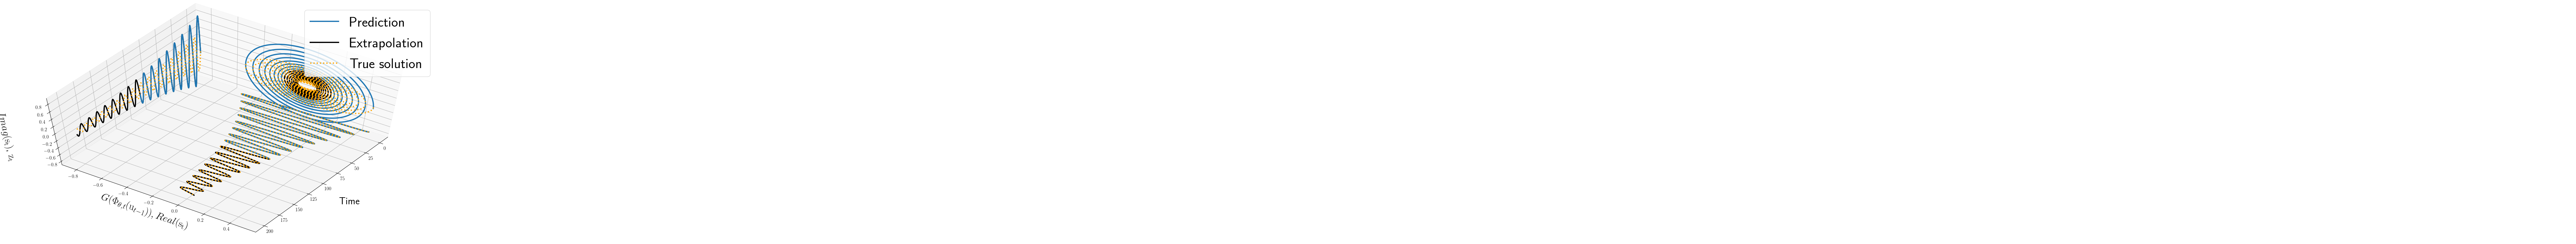

In [11]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import rc
rc('text', usetex = True)
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.close()

ranging = 20000

dpi = 100

fig = plt.figure(figsize = (1920/dpi,1080/dpi), dpi = dpi)
i = 20000
t = np.arange(0,200,0.01)
ax= fig.gca(projection='3d')
X = catalog.true_solution.real[:ranging]
Y = catalog.true_solution.imag[:ranging]
Z = np.zeros_like(catalog.true_solution.imag[:ranging])
pred_wn2=np.nan*np.zeros([predictionRK.shape[0],2])
pred_wn=np.nan*np.zeros([predictionRK.shape[0],2])
pred_wn[X_train.shape[0]:,:] = predictionRK[X_train.shape[0]:,:] 
pred_wn2[:X_train.shape[0],:] = predictionRK[:X_train.shape[0],:] 

line1,= ax.plot(pred_wn2[:i,0],(pred_wn2[:i,1]), np.zeros_like(pred_wn2[:i,0]),'#1f77b4',lw = 3 ,zdir = 'x')
line2,= ax.plot(pred_wn[:i,0],(pred_wn[:i,1]), np.zeros_like(pred_wn[:i,0]),'k',lw = 3, zdir = 'x')
line3,= ax.plot(catalog.true_solution.real[:i],(catalog.true_solution.imag[:i]), np.zeros_like(pred_wn[:i,0]),':',c = 'orange',lw = 3,zdir = 'x')

pred_wn=np.nan*np.zeros([predictionRK.shape[0],2])
pred_wn2=np.nan*np.zeros([predictionRK.shape[0],2])
cata_wn=np.nan*np.zeros([predictionRK.shape[0],1])
pred_wn2[:X_train.shape[0],0] = predictionRK[:X_train.shape[0],0] 
pred_wn[:i,0] = predictionRK[:i,0]
cata_wn[:i,:1] = catalog.true_solution.real[:i]


ax.plot(t, pred_wn[:,0], Z[:,0]-predictionRK[:,0].max()-0.2,'k', lw = 3, zdir = 'z')
ax.plot(t, pred_wn2[:,0], Z[:,0]-predictionRK[:,0].max()-0.2, '#1f77b4', lw = 3, zdir = 'z')
ax.plot(t, cata_wn[:,0], Z[:,0]-predictionRK[:,0].max()-0.2,':',c = 'orange',lw = 3, zdir = 'z')


pred_wn2=np.nan*np.zeros([predictionRK.shape[0],2])
pred_wn=np.nan*np.zeros([predictionRK.shape[0],2])
pred_wn[X_train.shape[0]:,:] = predictionRK[X_train.shape[0]:,:] 
pred_wn2[:X_train.shape[0],:] = predictionRK[:X_train.shape[0],:] 


pred_wn=np.nan*np.zeros([predictionRK.shape[0],2])
pred_wn2=np.nan*np.zeros([predictionRK.shape[0],2])
cata_wn=np.nan*np.zeros([predictionRK.shape[0],1])
pred_wn2[:X_train.shape[0],1] = predictionRK[:X_train.shape[0],1] 
pred_wn[:i,1] = predictionRK[:i,1]
cata_wn[:i,:1] = catalog.true_solution.imag[:i]



ax.plot(t, Z[:,0]-predictionRK[:,1].max()+0.1,pred_wn[:,1],'k', lw = 3, zdir = 'z')
ax.plot(t, Z[:,0]-predictionRK[:,1].max()+0.1,pred_wn2[:,1],'#1f77b4',lw = 3, zdir = 'z')
ax.plot(t, Z[:,0]-predictionRK[:,1].max()+0.1,cata_wn[:,0],':',c = 'orange',lw = 3, zdir = 'z')

ax.set_ylabel('$G(\Phi_{\\theta,t}(\mathrm{u}_{t-1})), Real(\mathrm{s_t})$',labelpad = 20, fontsize = 25)
ax.set_zlabel('$Imag(\mathrm{s_t})$, $\mathrm{z_t}$',labelpad = 40, fontsize = 25)
ax.set_xlabel('Time',labelpad = 40, fontsize = 25)

plt.legend([line1,line2,line3],['Prediction', 'Extrapolation','True solution'], loc = 1, fontsize = 35)
ax.view_init(60, 35)
plt.show()

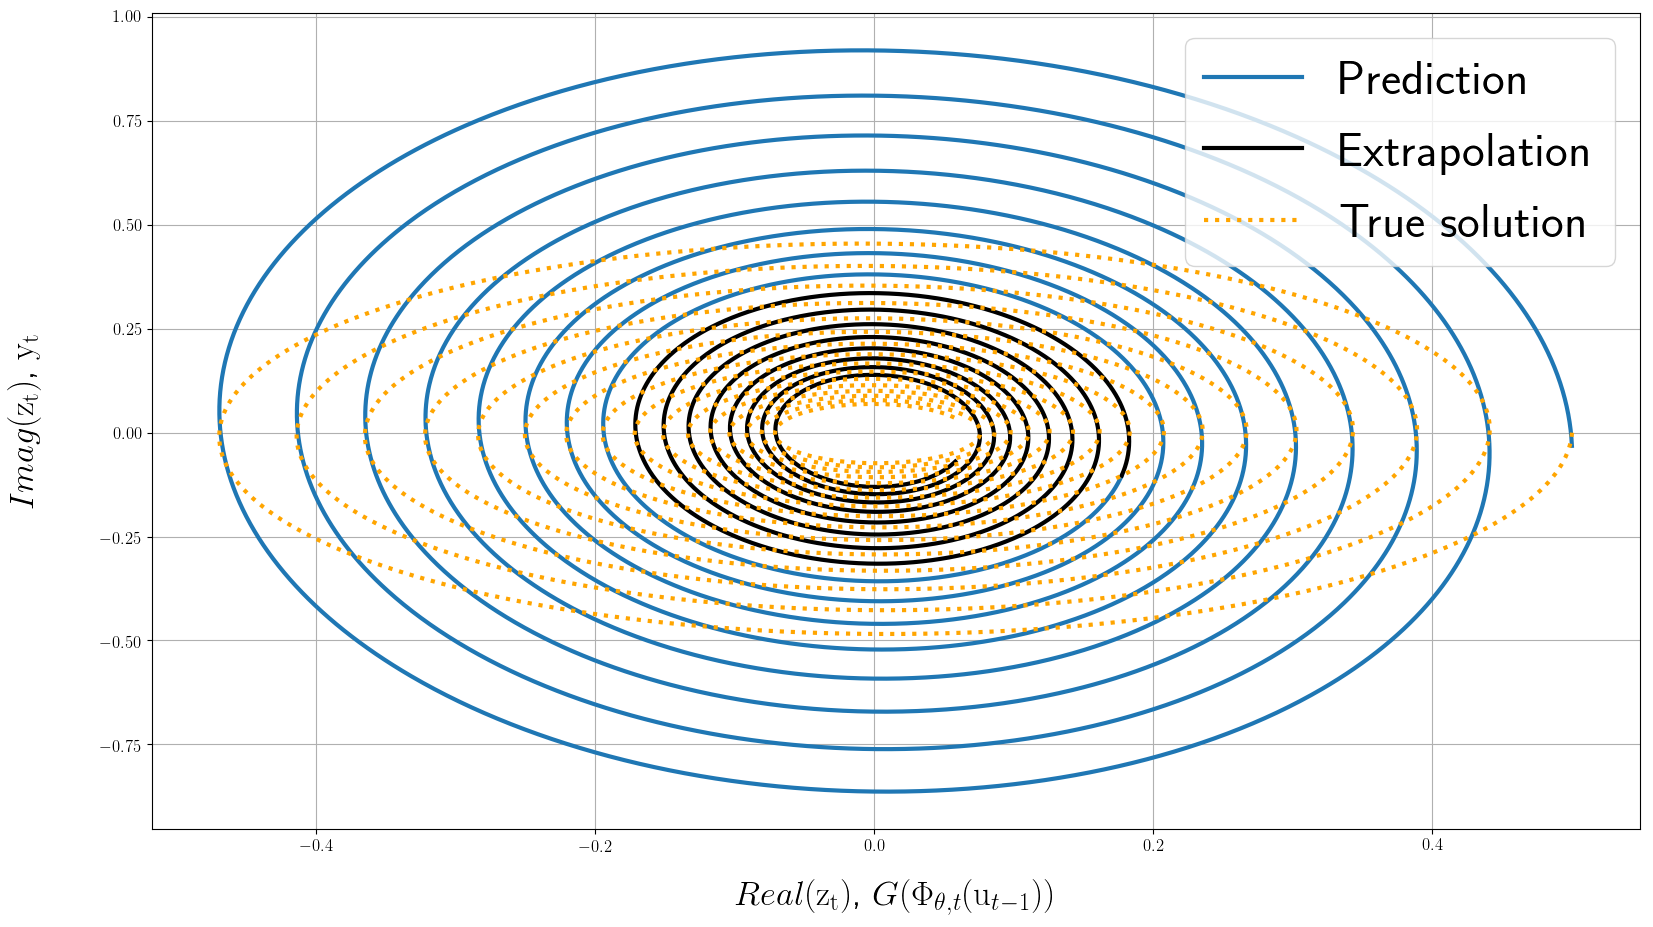

In [12]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import rc
rc('text', usetex = True)
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.close()

ranging = 20000
dpi = 100

fig = plt.figure(figsize = (1920/dpi,1080/dpi), dpi = dpi)
i = 20000
t = np.arange(0,200,0.01)
ax= fig.gca()
X = catalog.true_solution.real[:ranging]
Y = catalog.true_solution.imag[:ranging]
Z = np.zeros_like(catalog.true_solution.imag[:ranging])
pred_wn2=np.nan*np.zeros([predictionRK.shape[0],2])
pred_wn=np.nan*np.zeros([predictionRK.shape[0],2])
pred_wn[X_train.shape[0]:,:] = predictionRK[X_train.shape[0]:,:] 
pred_wn2[:X_train.shape[0],:] = predictionRK[:X_train.shape[0],:] 

line1,= ax.plot(pred_wn2[:i,0],(pred_wn2[:i,1]),'#1f77b4',lw = 3)
line2,= ax.plot(pred_wn[:i,0],(pred_wn[:i,1]),'k',lw = 3)
line3,= ax.plot(catalog.true_solution.real[:i],(catalog.true_solution.imag[:i]),':',c = 'orange',lw = 3)

ax.set_xlabel('$Real(\mathrm{z_t})$, $G(\Phi_{\\theta,t}(\mathrm{u}_{t-1}))$',labelpad = 20, fontsize = 25)
ax.set_ylabel('$Imag(\mathrm{z_t})$, $\mathrm{y_t}$',labelpad = 40, fontsize = 25)
plt.grid()
plt.legend([line1,line2,line3],['Prediction', 'Extrapolation','True solution'], loc = 1, fontsize = 35)
plt.show()

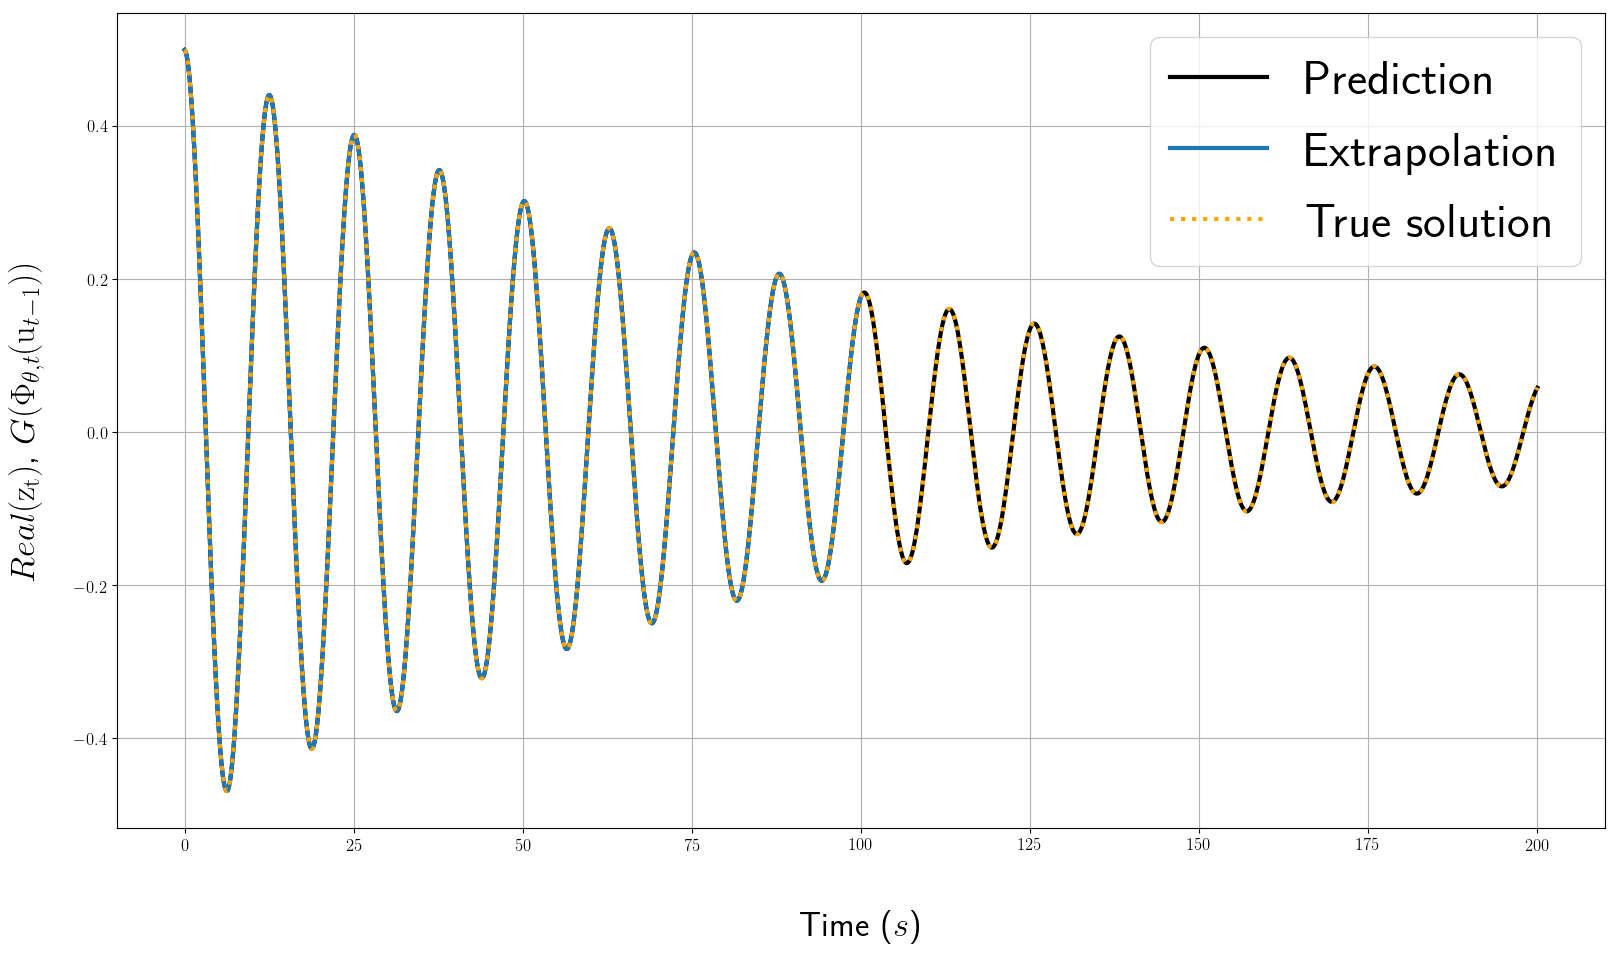

In [13]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import rc
rc('text', usetex = True)
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.close()




ranging = 20000


dpi = 100

fig = plt.figure(figsize = (1920/dpi,1080/dpi), dpi = dpi)
i = 20000
t = np.arange(0,200,0.01)
ax= fig.gca()
X = catalog.true_solution.real[:ranging]
Y = catalog.true_solution.imag[:ranging]
Z = np.zeros_like(catalog.true_solution.imag[:ranging])
pred_wn=np.nan*np.zeros([predictionRK.shape[0],2])
pred_wn2=np.nan*np.zeros([predictionRK.shape[0],2])
cata_wn=np.nan*np.zeros([predictionRK.shape[0],1])
pred_wn2[:X_train.shape[0],0] = predictionRK[:X_train.shape[0],0] 
pred_wn[:i,0] = predictionRK[:i,0]
cata_wn[:i,:1] = catalog.true_solution.real[:i]

line1,= ax.plot(t, pred_wn[:,0], 'k', lw = 3)
line2,= ax.plot(t, pred_wn2[:,0], '#1f77b4', lw = 3)
line3,= ax.plot(t, cata_wn[:,0], ':',c = 'orange',lw = 3)

ax.set_ylabel('$Real(\mathrm{z_t})$, $G(\Phi_{\\theta,t}(\mathrm{u}_{t-1}))$',labelpad = 20, fontsize = 25)
ax.set_xlabel('Time ($s$)',labelpad = 40, fontsize = 25)
plt.grid()
plt.legend([line1,line2,line3],['Prediction', 'Extrapolation','True solution'], loc = 1, fontsize = 35)
plt.show()

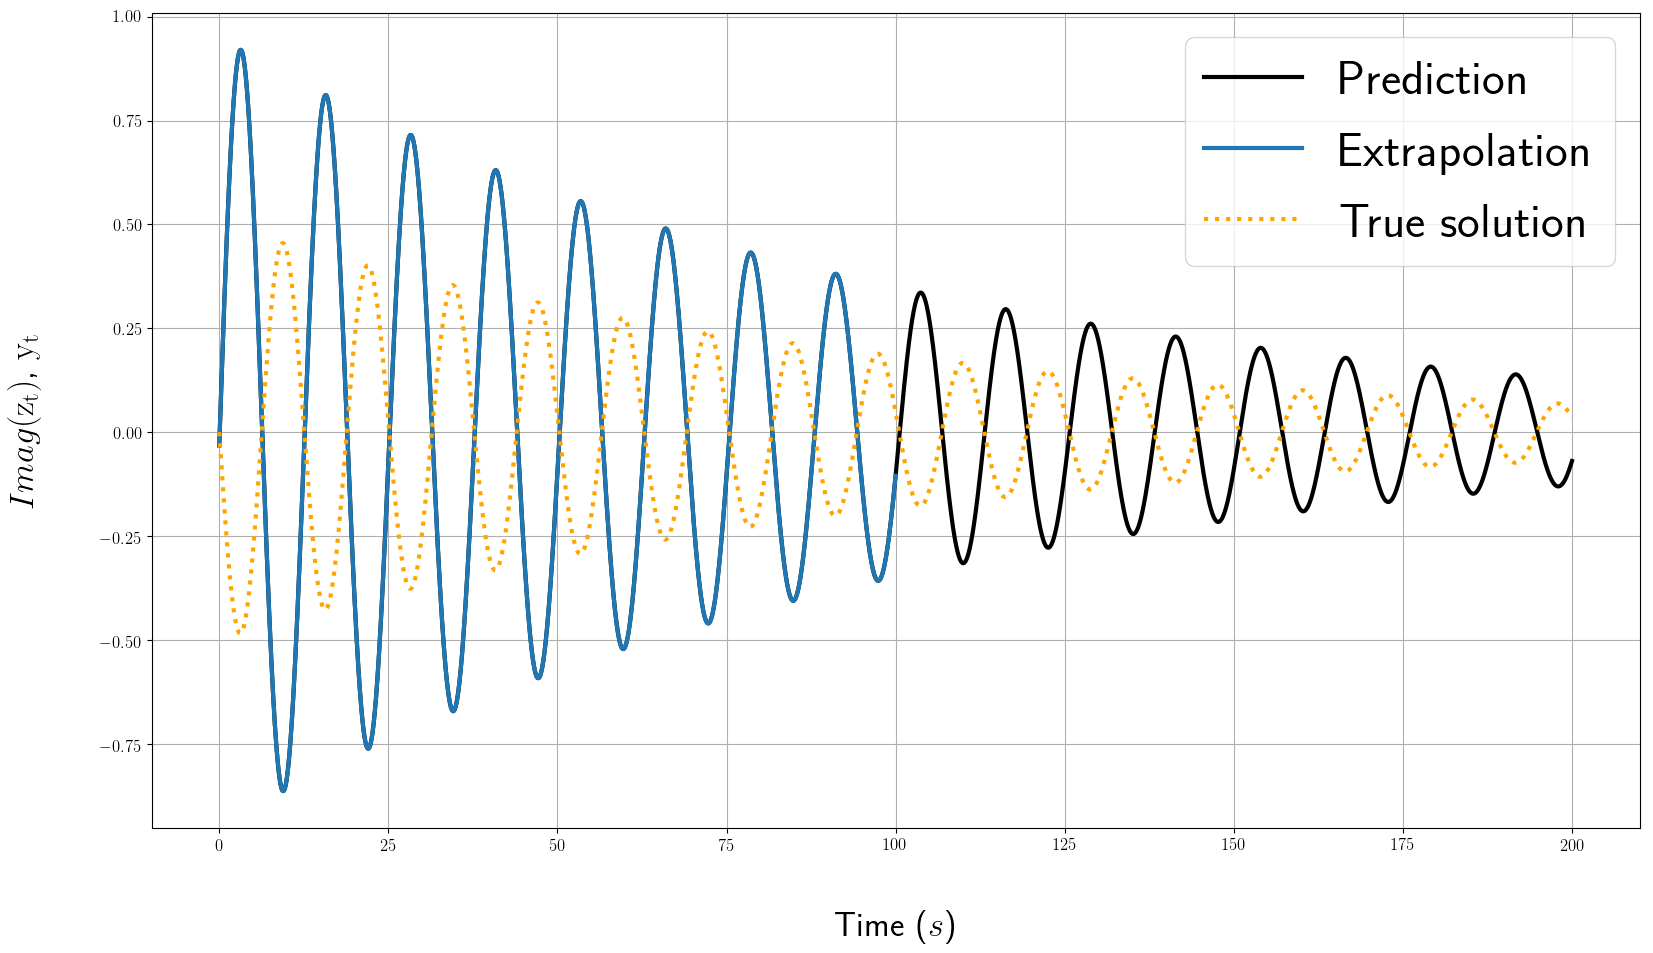

In [14]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import rc
rc('text', usetex = True)
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.close()




ranging = 20000


dpi = 100

fig = plt.figure(figsize = (1920/dpi,1080/dpi), dpi = dpi)
i = 20000
t = np.arange(0,200,0.01)
ax= fig.gca()
X = catalog.true_solution.real[:ranging]
Y = catalog.true_solution.imag[:ranging]
Z = np.zeros_like(catalog.true_solution.imag[:ranging])
pred_wn=np.nan*np.zeros([predictionRK.shape[0],2])
pred_wn2=np.nan*np.zeros([predictionRK.shape[0],2])
cata_wn=np.nan*np.zeros([predictionRK.shape[0],1])
pred_wn2[:X_train.shape[0],1] = predictionRK[:X_train.shape[0],1] 
pred_wn[:i,1] = predictionRK[:i,1]
cata_wn[:i,:1] = catalog.true_solution.imag[:i]



line1, = ax.plot(t, pred_wn[:,1],'k', lw = 3)
line2, = ax.plot(t, pred_wn2[:,1],'#1f77b4',lw = 3)
line3, = ax.plot(t, cata_wn[:,0],':',c = 'orange',lw = 3)

ax.set_ylabel('$Imag(\mathrm{z_t})$, $\mathrm{y_t}$',labelpad = 40, fontsize = 25)
ax.set_xlabel('Time ($s$)',labelpad = 40, fontsize = 25)
plt.grid()
plt.legend([line1,line2,line3],['Prediction', 'Extrapolation','True solution'], loc = 1, fontsize = 35)
plt.show()

# GET NEW SIMULATION FROM ANOTHER INITIAL CONDITION

In [15]:
RKError2=np.zeros(20000)
predictionRK=np.nan*np.zeros([20000,2])
tmp1=aug_inp[:1,:]
tmp1[0,0] = 1.0
dt=(torch.from_numpy(np.array(0.01).reshape((1,1))).float())
for m in range(0,20000):
    predictionRK[m,:]=modelRINN(tmp1,dt)[0].data.numpy()
    tmp1=np.reshape(predictionRK[m,:],(1,2))
    tmp1=(torch.from_numpy(tmp1).float())

In [16]:
# generating training data
class GD:
    model = 'Adv_Dif_1D'
    class parameters:
        w = -0.01-0.5j
        x0 = 1.0
        t0 = 0
    dt_integration =0.01# integration time
    dt_states = 1 # number of integeration times between consecutive states (for xt and catalog)
    dt_obs = 8# number of integration times between consecutive observations (for yo)
    var_obs = np.array([0,1]) # indices of the observed variables
    nb_loop_train = 1000.1 # size of the catalog
    nb_loop_test = 100 # size of the true state and noisy observations
    sigma2_catalog = 0.0 # variance of the model error to generate the catalog
    sigma2_obs = 2.0 # variance of the observation error to generate observation
    
# run the data generation
catalog, xt, yo = generate_data(GD)

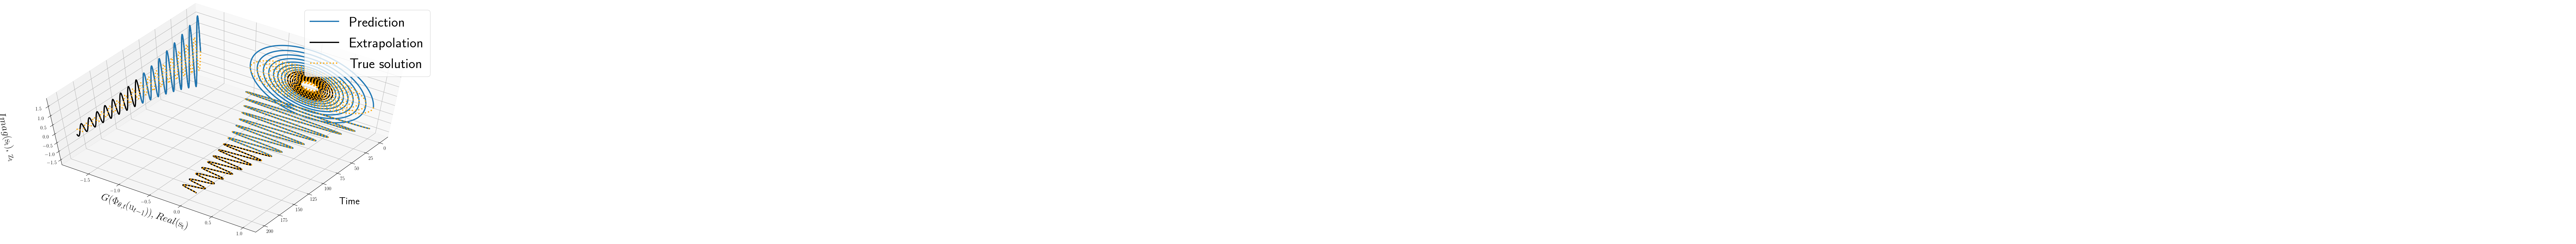

In [17]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import rc
rc('text', usetex = True)
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.close()

dpi = 100

fig = plt.figure(figsize = (1920/dpi,1080/dpi), dpi = dpi)
i = 20000
t = np.arange(0,200,0.01)
ax= fig.gca(projection='3d')
X = catalog.true_solution.real[:ranging]
Y = catalog.true_solution.imag[:ranging]
Z = np.zeros_like(catalog.true_solution.imag[:ranging])
pred_wn2=np.nan*np.zeros([predictionRK.shape[0],2])
pred_wn=np.nan*np.zeros([predictionRK.shape[0],2])
pred_wn[X_train.shape[0]:,:] = predictionRK[X_train.shape[0]:,:]
pred_wn2[:X_train.shape[0],:] = predictionRK[:X_train.shape[0],:]

line1,= ax.plot(pred_wn2[:i,0],(pred_wn2[:i,1]), np.zeros_like(pred_wn2[:i,0]),'#1f77b4',lw = 3 ,zdir = 'x')
line2,= ax.plot(pred_wn[:i,0],(pred_wn[:i,1]), np.zeros_like(pred_wn[:i,0]),'k',lw = 3, zdir = 'x')
line3,= ax.plot(catalog.true_solution.real[:i],(catalog.true_solution.imag[:i]), np.zeros_like(pred_wn[:i,0]),':',c = 'orange',lw = 3,zdir = 'x')

pred_wn=np.nan*np.zeros([predictionRK.shape[0],2])
pred_wn2=np.nan*np.zeros([predictionRK.shape[0],2])
cata_wn=np.nan*np.zeros([predictionRK.shape[0],1])
pred_wn2[:X_train.shape[0],0] = predictionRK[:X_train.shape[0],0] 
pred_wn[:i,0] = predictionRK[:i,0]
cata_wn[:i,:1] = catalog.true_solution.real[:i]


ax.plot(t, pred_wn[:,0], Z[:,0]-predictionRK[:,0].max()-0.2,'k', lw = 3, zdir = 'z')
ax.plot(t, pred_wn2[:,0], Z[:,0]-predictionRK[:,0].max()-0.2, '#1f77b4', lw = 3, zdir = 'z')
ax.plot(t, cata_wn[:,0], Z[:,0]-predictionRK[:,0].max()-0.2,':',c = 'orange',lw = 3, zdir = 'z')


pred_wn2=np.nan*np.zeros([predictionRK.shape[0],2])
pred_wn=np.nan*np.zeros([predictionRK.shape[0],2])
pred_wn[X_train.shape[0]:,:] = predictionRK[X_train.shape[0]:,:] 
pred_wn2[:X_train.shape[0],:] = predictionRK[:X_train.shape[0],:] 


pred_wn=np.nan*np.zeros([predictionRK.shape[0],2])
pred_wn2=np.nan*np.zeros([predictionRK.shape[0],2])
cata_wn=np.nan*np.zeros([predictionRK.shape[0],1])
pred_wn2[:X_train.shape[0],1] = predictionRK[:X_train.shape[0],1] 
pred_wn[:i,1] = predictionRK[:i,1]
cata_wn[:i,:1] = catalog.true_solution.imag[:i]



ax.plot(t, Z[:,0]-predictionRK[:,1].max()+0.1,pred_wn[:,1],'k', lw = 3, zdir = 'z')
ax.plot(t, Z[:,0]-predictionRK[:,1].max()+0.1,pred_wn2[:,1],'#1f77b4',lw = 3, zdir = 'z')
ax.plot(t, Z[:,0]-predictionRK[:,1].max()+0.1,cata_wn[:,0],':',c = 'orange',lw = 3, zdir = 'z')

ax.set_ylabel('$G(\Phi_{\\theta,t}(\mathrm{u}_{t-1})), Real(\mathrm{s_t})$',labelpad = 20, fontsize = 25)
ax.set_zlabel('$Imag(\mathrm{s_t})$, $\mathrm{z_t}$',labelpad = 40, fontsize = 25)
ax.set_xlabel('Time',labelpad = 40, fontsize = 25)

plt.legend([line1,line2,line3],['Prediction', 'Extrapolation','True solution'], loc = 1, fontsize = 35)
ax.view_init(60, 35)
plt.show()

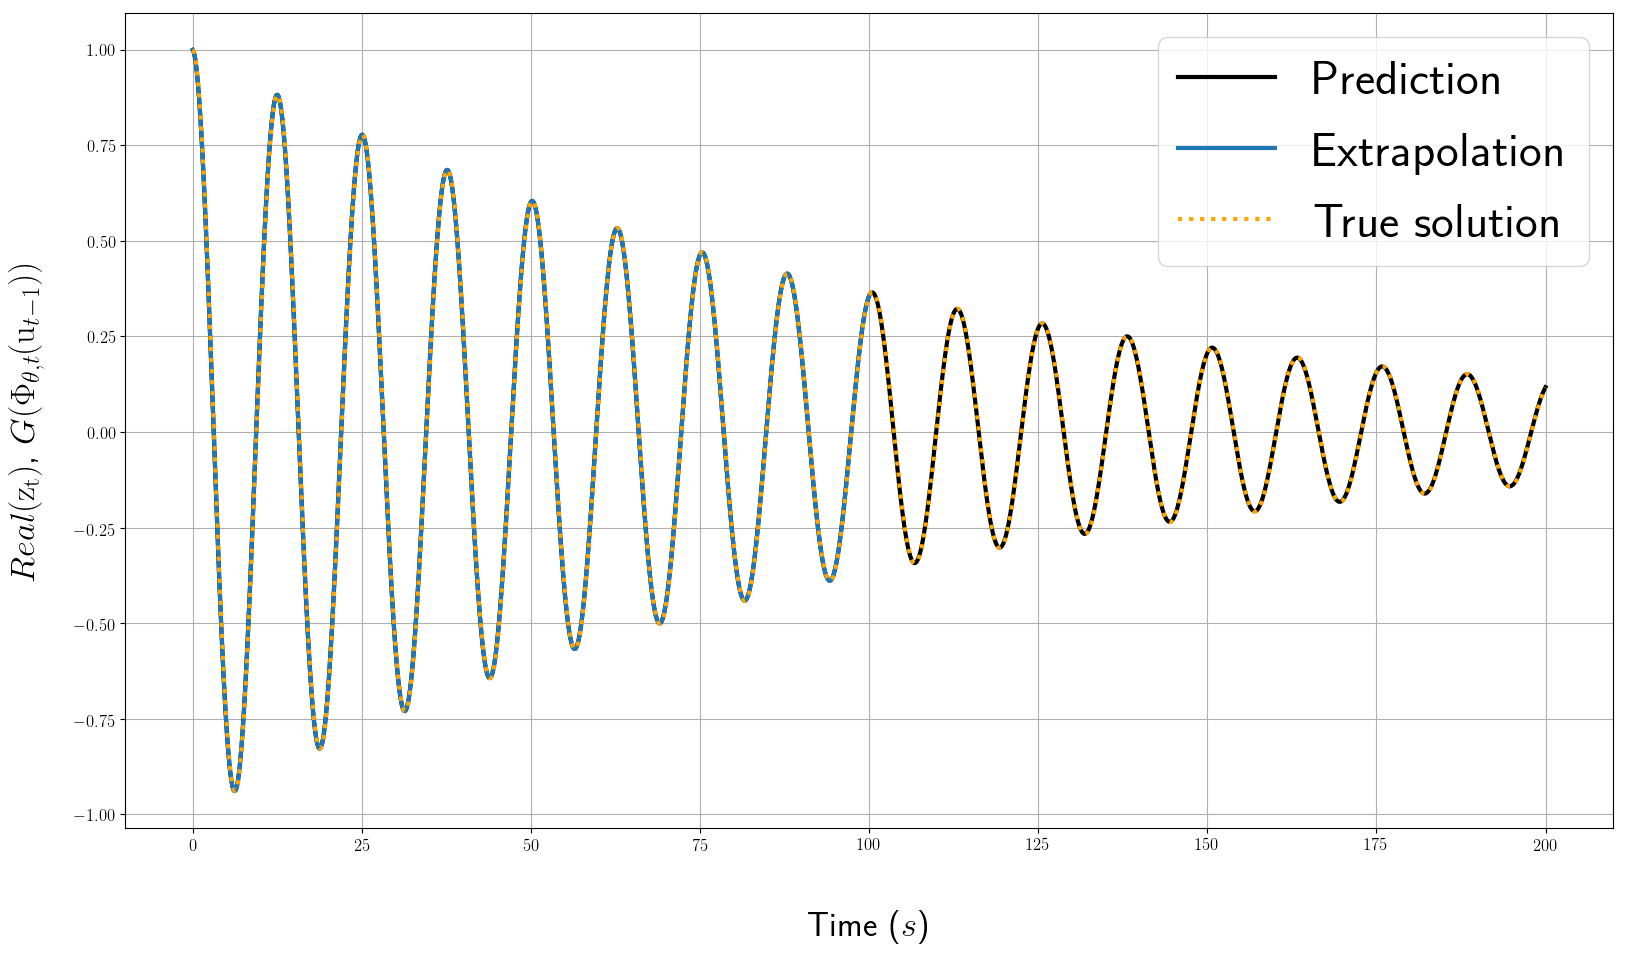

In [18]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import rc
rc('text', usetex = True)
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.close()




ranging = 20000


dpi = 100

fig = plt.figure(figsize = (1920/dpi,1080/dpi), dpi = dpi)
i = 20000
t = np.arange(0,200,0.01)
ax= fig.gca()
X = catalog.true_solution.real[:ranging]
Y = catalog.true_solution.imag[:ranging]
Z = np.zeros_like(catalog.true_solution.imag[:ranging])
pred_wn=np.nan*np.zeros([predictionRK.shape[0],2])
pred_wn2=np.nan*np.zeros([predictionRK.shape[0],2])
cata_wn=np.nan*np.zeros([predictionRK.shape[0],1])
pred_wn2[:X_train.shape[0],0] = predictionRK[:X_train.shape[0],0] 
pred_wn[:i,0] = predictionRK[:i,0]
cata_wn[:i,:1] = catalog.true_solution.real[:i]

line1,= ax.plot(t, pred_wn[:,0], 'k', lw = 3)
line2,= ax.plot(t, pred_wn2[:,0], '#1f77b4', lw = 3)
line3,= ax.plot(t, cata_wn[:,0], ':',c = 'orange',lw = 3)

ax.set_ylabel('$Real(\mathrm{z_t})$, $G(\Phi_{\\theta,t}(\mathrm{u}_{t-1}))$',labelpad = 20, fontsize = 25)
ax.set_xlabel('Time ($s$)',labelpad = 40, fontsize = 25)
plt.grid()
plt.legend([line1,line2,line3],['Prediction', 'Extrapolation','True solution'], loc = 1, fontsize = 35)
plt.savefig('real_sol_pred_test.pdf')
plt.show()

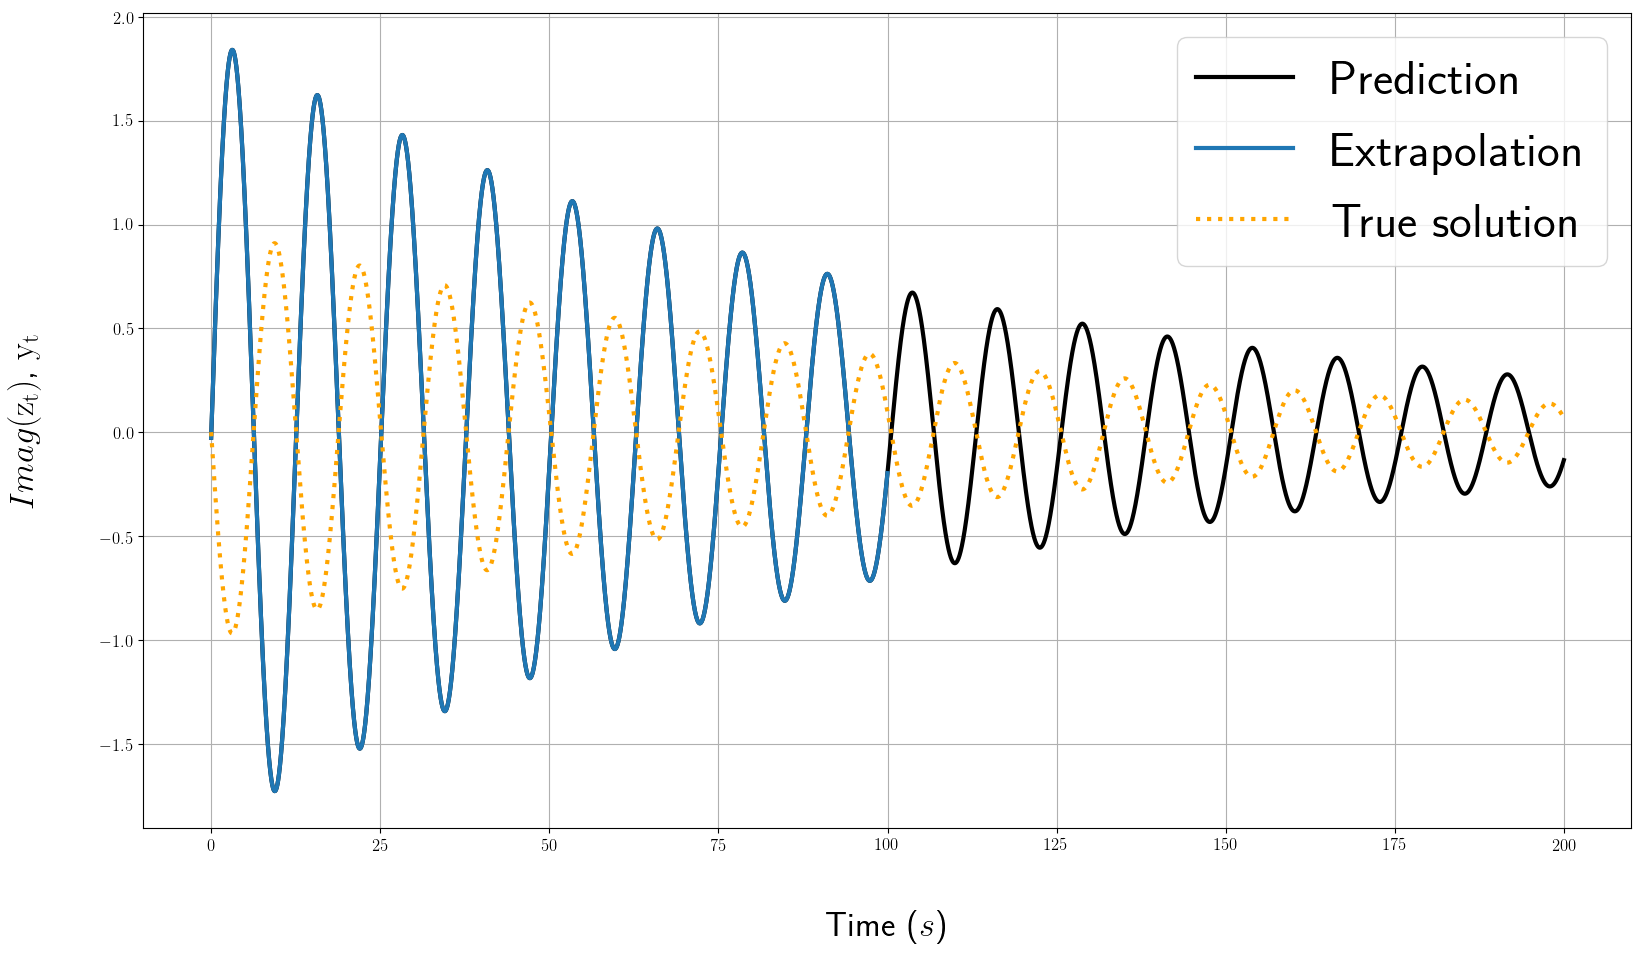

In [19]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import rc
rc('text', usetex = True)
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.close()




ranging = 20000


dpi = 100

fig = plt.figure(figsize = (1920/dpi,1080/dpi), dpi = dpi)
i = 20000
t = np.arange(0,200,0.01)
ax= fig.gca()
X = catalog.true_solution.real[:ranging]
Y = catalog.true_solution.imag[:ranging]
Z = np.zeros_like(catalog.true_solution.imag[:ranging])
pred_wn=np.nan*np.zeros([predictionRK.shape[0],2])
pred_wn2=np.nan*np.zeros([predictionRK.shape[0],2])
cata_wn=np.nan*np.zeros([predictionRK.shape[0],1])
pred_wn2[:X_train.shape[0],1] = predictionRK[:X_train.shape[0],1] 
pred_wn[:i,1] = predictionRK[:i,1]
cata_wn[:i,:1] = catalog.true_solution.imag[:i]



line1, = ax.plot(t, pred_wn[:,1],'k', lw = 3)
line2, = ax.plot(t, pred_wn2[:,1],'#1f77b4',lw = 3)
line3, = ax.plot(t, cata_wn[:,0],':',c = 'orange',lw = 3)

ax.set_ylabel('$Imag(\mathrm{z_t})$, $\mathrm{y_t}$',labelpad = 40, fontsize = 25)
ax.set_xlabel('Time ($s$)',labelpad = 40, fontsize = 25)
plt.grid()
plt.legend([line1,line2,line3],['Prediction', 'Extrapolation','True solution'], loc = 1, fontsize = 35)
plt.show()